# **Part I**

Import necessary libraries and modules

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Conv2DTranspose, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import fashion_mnist,cifar10
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import  LeakyReLU, Conv2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score
from typing import Tuple
from tensorflow.python.ops.gen_dataset_ops import PrefetchDataset
from numpy.random import randn, randint
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ImageDataGenerator is used to perform data augmentation, which is a technique to artificially increase the size of the dataset by creating modified versions of the images. This includes rotation, rescaling, shear transformation, zooming, and horizontal flipping.

A validation split of 20% is also set here.

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=(0.75,1.25),
    horizontal_flip=True,
    validation_split=0.2
)

flow_from_directory is used to load images from the specified directory, and it also automatically labels the images based on the subdirectory they are in.

The images are resized to 224x224 pixels and are loaded in batches of 32. The class_mode is set to ‘categorical’ for multi-class classification.

The subset parameter is used to divide the images into training and validation sets based on the validation split specified in ImageDataGenerator.

In [ ]:
train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/skin/skin-images",
    # https://drive.google.com/drive/shared-with-me
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 140 images belonging to 3 classes.


In [ ]:
validation_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/skin/skin-images",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 33 images belonging to 3 classes.


The VGG16 model pre-trained on the ImageNet dataset is loaded. The top layers of the model, which contain the fully connected layers, are not included.

The input shape is set to (224, 224, 3) for the images. The weights of the VGG16 model are frozen to preserve the learned features.

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


A new model is created using the Sequential API, and the VGG16 model is added as the base.
This is followed by a Flatten layer to convert the 3D outputs to 1D, then two Dense layers (also known as fully connected layers) with ReLU activation and Dropout for regularization.
A BatchNormalization layer is added for faster convergence and finally a Dense layer with softmax activation for outputting the probabilities for each class.

In [ ]:
model_vgg = Sequential([
    vgg_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(3, activation='softmax')
])

model_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 batch_normalization (Batch  (None, 1024)              4

The model is compiled with the Adam optimizer, categorical cross-entropy loss for multi-class classification, and accuracy as the evaluation metric.

In [ ]:
model_vgg.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

The model is trained for 100 epochs using the training and validation data.

In [ ]:
history = model_vgg.fit(train_generator, epochs=100, validation_data=validation_generator)

Epoch 1/100
5/5 [==============================] - 66s 10s/step - loss: 1.4592 - accuracy: 0.3786 - val_loss: 2.7555 - val_accuracy: 0.3333
Epoch 2/100
5/5 [==============================] - 8s 2s/step - loss: 1.2182 - accuracy: 0.4429 - val_loss: 4.3525 - val_accuracy: 0.3333
Epoch 3/100
5/5 [==============================] - 6s 1s/step - loss: 1.6028 - accuracy: 0.2929 - val_loss: 4.5802 - val_accuracy: 0.3333
Epoch 4/100
5/5 [==============================] - 8s 2s/step - loss: 1.7315 - accuracy: 0.3286 - val_loss: 3.2234 - val_accuracy: 0.3333
Epoch 5/100
5/5 [==============================] - 6s 1s/step - loss: 1.4988 - accuracy: 0.3571 - val_loss: 2.2233 - val_accuracy: 0.3333
Epoch 6/100
5/5 [==============================] - 7s 1s/step - loss: 1.4840 - accuracy: 0.4357 - val_loss: 1.7821 - val_accuracy: 0.4242
Epoch 7/100
5/5 [==============================] - 8s 2s/step - loss: 1.3719 - accuracy: 0.4071 - val_loss: 1.6574 - val_accuracy: 0.3939
Epoch 8/100
5/5 [===============

Print accuracy: The validation accuracy of the model after training is printed.

In [ ]:
average_val_accuracy = np.mean(history.history['val_accuracy'])
print("Average Validation Accuracy:", average_val_accuracy)

median_val_accuracy = np.median(history.history['val_accuracy'])
print("Median Validation Accuracy:", median_val_accuracy)

max_val_accuracy = np.max(history.history['val_accuracy'])
print("Maximum Validation Accuracy:", max_val_accuracy)


Average Validation Accuracy: 0.4681818225979805
Median Validation Accuracy: 0.5
Maximum Validation Accuracy: 0.6363636255264282


Create a new generator for evaluation with shuffle set to False to ensure consistent order of samples

In [ ]:
validation_generator_eval = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/skin/skin-images",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 33 images belonging to 3 classes.


Generate classification report

In [ ]:
y_true = validation_generator_eval.classes
y_pred = np.argmax(model_vgg.predict(validation_generator_eval), axis=-1)

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_true, y_pred, target_names=validation_generator_eval.class_indices.keys())
print(report)


2/2 [==============================] - 1s 152ms/step
Accuracy: 0.45454545454545453
              precision    recall  f1-score   support

   Carcinoma       1.00      0.80      0.89        10
    Melanoma       0.31      0.42      0.36        12
       Nevus       0.22      0.18      0.20        11

    accuracy                           0.45        33
   macro avg       0.51      0.47      0.48        33
weighted avg       0.49      0.45      0.47        33



VGG16 without data augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/skin/skin-images",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/skin/skin-images",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

validation_generator_eval = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/skin/skin-images",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False

model_vgg = Sequential([
    vgg_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(3, activation='softmax')
])

model_vgg.summary()

model_vgg.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model_vgg.fit(train_generator, epochs=100, validation_data=validation_generator)

Found 140 images belonging to 3 classes.
Found 33 images belonging to 3 classes.
Found 33 images belonging to 3 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              25691136  
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         

In [ ]:
average_val_accuracy = np.mean(history.history['val_accuracy'])
print("Average Validation Accuracy:", average_val_accuracy)

median_val_accuracy = np.median(history.history['val_accuracy'])
print("Median Validation Accuracy:", median_val_accuracy)

max_val_accuracy = np.max(history.history['val_accuracy'])
print("Maximum Validation Accuracy:", max_val_accuracy)

Average Validation Accuracy: 0.3906060701608658
Median Validation Accuracy: 0.39393940567970276
Maximum Validation Accuracy: 0.5454545617103577


In [ ]:
y_true = validation_generator_eval.classes
y_pred = np.argmax(model_vgg.predict(validation_generator_eval), axis=-1)

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_true, y_pred, target_names=validation_generator_eval.class_indices.keys())
print(report)


2/2 [==============================] - 1s 160ms/step
Accuracy: 0.45454545454545453
              precision    recall  f1-score   support

   Carcinoma       1.00      1.00      1.00        10
    Melanoma       0.25      0.25      0.25        12
       Nevus       0.18      0.18      0.18        11

    accuracy                           0.45        33
   macro avg       0.48      0.48      0.48        33
weighted avg       0.45      0.45      0.45        33



Now, the same proccess is done using ResNet50.

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=(0.75,1.25),
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/skin/skin-images",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/skin/skin-images",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

validation_generator_eval = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/skin/skin-images",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Use ResNet50 instead of VGG16
for layer in resnet_model.layers:
    layer.trainable = False

model_resnet = Sequential([
    resnet_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(3, activation='softmax')
])

model_resnet.summary()

model_resnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

Found 140 images belonging to 3 classes.
Found 33 images belonging to 3 classes.
Found 33 images belonging to 3 classes.
94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_9 (Dense)             (None, 1024)              102761472 
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 1024)              1049600   
                                                                 


In [ ]:
history = model_resnet.fit(train_generator, epochs=100, validation_data=validation_generator)

Epoch 1/100
5/5 [==============================] - 17s 2s/step - loss: 1.6376 - accuracy: 0.2929 - val_loss: 2.0371 - val_accuracy: 0.3030
Epoch 2/100
5/5 [==============================] - 6s 1s/step - loss: 1.6984 - accuracy: 0.2929 - val_loss: 2.7443 - val_accuracy: 0.3030
Epoch 3/100
5/5 [==============================] - 8s 2s/step - loss: 1.5343 - accuracy: 0.3357 - val_loss: 2.5958 - val_accuracy: 0.3333
Epoch 4/100
5/5 [==============================] - 6s 1s/step - loss: 1.6028 - accuracy: 0.3214 - val_loss: 2.6251 - val_accuracy: 0.3333
Epoch 5/100
5/5 [==============================] - 8s 2s/step - loss: 1.5160 - accuracy: 0.3286 - val_loss: 2.2230 - val_accuracy: 0.3333
Epoch 6/100
5/5 [==============================] - 6s 1s/step - loss: 1.6075 - accuracy: 0.3214 - val_loss: 1.5671 - val_accuracy: 0.3333
Epoch 7/100
5/5 [==============================] - 8s 2s/step - loss: 1.5277 - accuracy: 0.3286 - val_loss: 1.4420 - val_accuracy: 0.3333
Epoch 8/100
5/5 [================

In [ ]:
average_val_accuracy = np.mean(history.history['val_accuracy'])
print("Average Validation Accuracy:", average_val_accuracy)

median_val_accuracy = np.median(history.history['val_accuracy'])
print("Median Validation Accuracy:", median_val_accuracy)

max_val_accuracy = np.max(history.history['val_accuracy'])
print("Maximum Validation Accuracy:", max_val_accuracy)

Average Validation Accuracy: 0.33818182826042176
Median Validation Accuracy: 0.3636363744735718
Maximum Validation Accuracy: 0.3636363744735718


In [ ]:
y_true = validation_generator_eval.classes
y_pred = np.argmax(model_resnet.predict(validation_generator_eval), axis=-1)

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_true, y_pred, target_names=validation_generator_eval.class_indices.keys())
print(report)

2/2 [==============================] - 5s 133ms/step
Accuracy: 0.36363636363636365
              precision    recall  f1-score   support

   Carcinoma       0.00      0.00      0.00        10
    Melanoma       0.36      1.00      0.53        12
       Nevus       0.00      0.00      0.00        11

    accuracy                           0.36        33
   macro avg       0.12      0.33      0.18        33
weighted avg       0.13      0.36      0.19        33



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


resnet without data augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/skin/skin-images",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/skin/skin-images",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

validation_generator_eval = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/skin/skin-images",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Use ResNet50 instead of VGG16
for layer in resnet_model.layers:
    layer.trainable = False

model_resnet = Sequential([
    resnet_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(3, activation='softmax')
])

model_resnet.summary()

model_resnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

Found 140 images belonging to 3 classes.
Found 33 images belonging to 3 classes.
Found 33 images belonging to 3 classes.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_12 (Dense)            (None, 1024)              102761472 
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         

In [ ]:
history = model_resnet.fit(train_generator, epochs=100, validation_data=validation_generator)

Epoch 1/100
5/5 [==============================] - 11s 1s/step - loss: 1.6920 - accuracy: 0.3500 - val_loss: 1.3407 - val_accuracy: 0.3636
Epoch 2/100
5/5 [==============================] - 6s 1s/step - loss: 1.6075 - accuracy: 0.3286 - val_loss: 1.1477 - val_accuracy: 0.3636
Epoch 3/100
5/5 [==============================] - 5s 920ms/step - loss: 1.6415 - accuracy: 0.3071 - val_loss: 1.1429 - val_accuracy: 0.3333
Epoch 4/100
5/5 [==============================] - 5s 1s/step - loss: 1.5156 - accuracy: 0.3643 - val_loss: 1.2345 - val_accuracy: 0.3333
Epoch 5/100
5/5 [==============================] - 5s 1s/step - loss: 1.6515 - accuracy: 0.4143 - val_loss: 1.3342 - val_accuracy: 0.3333
Epoch 6/100
5/5 [==============================] - 5s 946ms/step - loss: 1.4772 - accuracy: 0.3429 - val_loss: 1.3134 - val_accuracy: 0.3333
Epoch 7/100
5/5 [==============================] - 6s 1s/step - loss: 1.4583 - accuracy: 0.3500 - val_loss: 1.5474 - val_accuracy: 0.3333
Epoch 8/100
5/5 [==========

In [ ]:
average_val_accuracy = np.mean(history.history['val_accuracy'])
print("Average Validation Accuracy:", average_val_accuracy)

median_val_accuracy = np.median(history.history['val_accuracy'])
print("Median Validation Accuracy:", median_val_accuracy)

max_val_accuracy = np.max(history.history['val_accuracy'])
print("Maximum Validation Accuracy:", max_val_accuracy)

Average Validation Accuracy: 0.34454546481370923
Median Validation Accuracy: 0.3333333432674408
Maximum Validation Accuracy: 0.3636363744735718


In [ ]:
y_true = validation_generator_eval.classes

y_pred = np.argmax(model_resnet.predict(validation_generator_eval), axis=-1)

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_true, y_pred, target_names=validation_generator_eval.class_indices.keys())
print(report)

2/2 [==============================] - 2s 134ms/step
Accuracy: 0.3888888888888889
              precision    recall  f1-score   support

   Carcinoma       0.00      0.00      0.00        10
    Melanoma       0.39      1.00      0.56        14
       Nevus       0.00      0.00      0.00        12

    accuracy                           0.39        36
   macro avg       0.13      0.33      0.19        36
weighted avg       0.15      0.39      0.22        36



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **1.B Architecture of VGG16 and ResNet50**

**VGG16 Architecture:**

VGG16 is a convolutional neural network model proposed by the Visual Geometry Group from the University of Oxford, that reached top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes.

 VGG16 architecture:

1. **Input Layer**: The input to the covolutional layers is a 224x224 RGB image which passes through the network.

2. **Convolutional Layers**: The network contains 13 convolutional layers. They use filters with a very small receptive field: 3x3 (which is the smallest size to capture the notion of left/right, up/down, center).

3. **Max Pooling Layers**: Five max pooling layers follow some of the convolutional layers. They are used to reduce the volume size, prevent overfitting, and reduce computation.

4. **Fully Connected Layers**: The last three layers of the VGG16 architecture are fully connected layers. They have 4096, 4096, and 1000 nodes each. The final layer uses a softmax activation function for outputting class probabilities.

5. **Activation Function**: All hidden layers use ReLU (Rectified Linear Units) as their activation function.

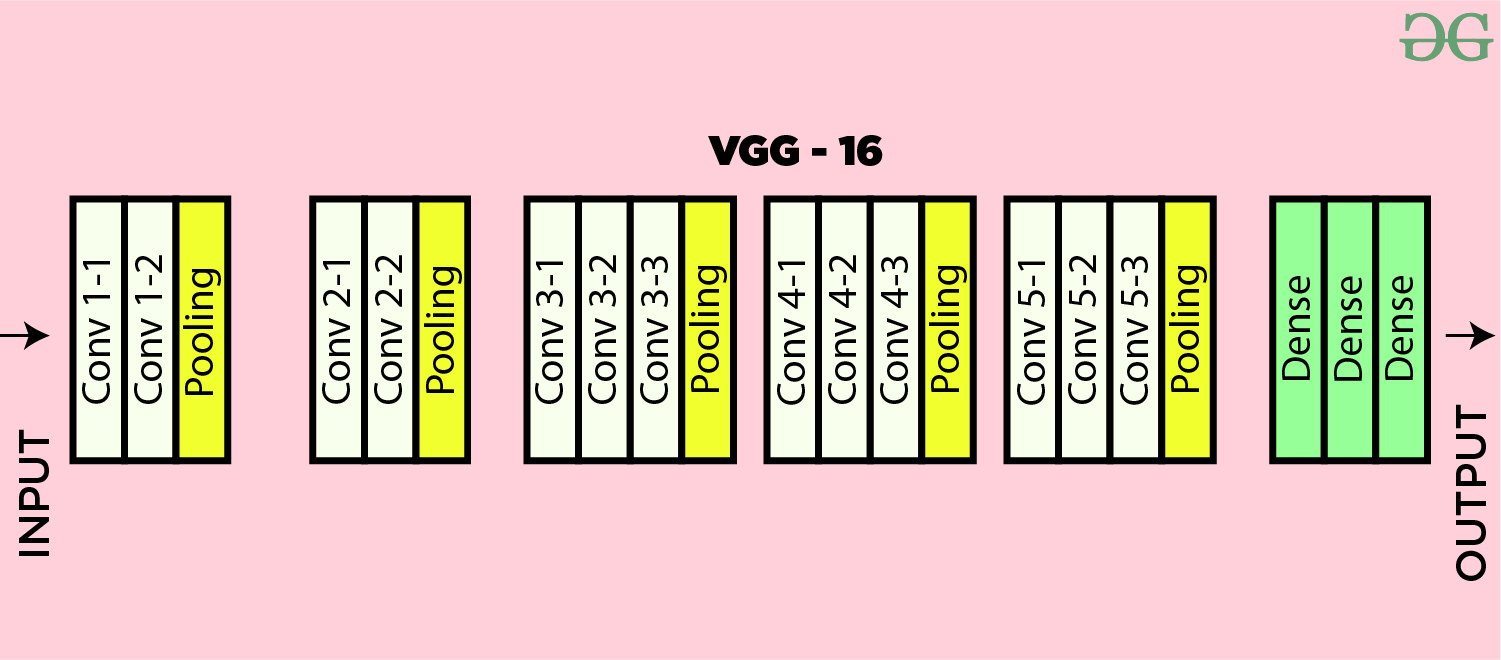

In [ ]:
from IPython.display import Image
Image(filename='/content/vgg.jpg')

### ResNet50 Architecture

ResNet50 is a convolutional neural network model developed by Microsoft Research that introduced the concept of "Residual Learning" to solve the problem of vanishing gradients in deep neural networks. ResNet50 achieved state-of-the-art performance on ImageNet, a dataset with over 14 million images and 1000 classes.

#### ResNet50 Architecture:

1. **Input Layer**:
   - The input to ResNet50 is a 224x224 RGB image.

2. **Convolutional Layers**:
   - ResNet50 has a total of 48 convolutional layers. These layers are organized into several stages, each containing a series of residual blocks.

3. **Residual Blocks**:
   - The core idea of ResNet is the residual block, which allows the network to learn residual functions with reference to the layer inputs, instead of learning unreferenced functions.
   - A residual block typically consists of three layers: two 1x1 convolutions and one 3x3 convolution, with shortcut connections that skip one or more layers.

4. **Identity and Convolutional Shortcut Connections**:
   - Shortcut connections skip one or more layers by performing identity mapping, and their outputs are added to the outputs of the stacked layers.
   - If the dimensions change (due to downsampling), a projection shortcut (using 1x1 convolutions) is used to match the dimensions.

5. **Stage-wise Structure**:
   - The network consists of five stages:
     - **Stage 1**: A 7x7 convolutional layer with 64 filters and a stride of 2, followed by a max pooling layer.
     - **Stage 2**: Consists of 3 residual blocks, with each block containing 3 layers of convolutions.
     - **Stage 3**: Consists of 4 residual blocks.
     - **Stage 4**: Consists of 6 residual blocks.
     - **Stage 5**: Consists of 3 residual blocks.
   
6. **Max Pooling Layers**:
   - A max pooling layer follows the first 7x7 convolutional layer to reduce the spatial dimensions.

7. **Global Average Pooling**:
   - After the final convolutional layer, a global average pooling layer is used to reduce the spatial dimensions to 1x1, which reduces the number of parameters and prevents overfitting.

8. **Fully Connected Layer**:
   - The global average pooling layer is followed by a fully connected layer with 1000 nodes (one for each class in ImageNet), using a softmax activation function to output class probabilities.

9. **Activation Function**:
   - All hidden layers use ReLU (Rectified Linear Units) as their activation function, which introduces non-linearity and helps the network learn complex patterns.

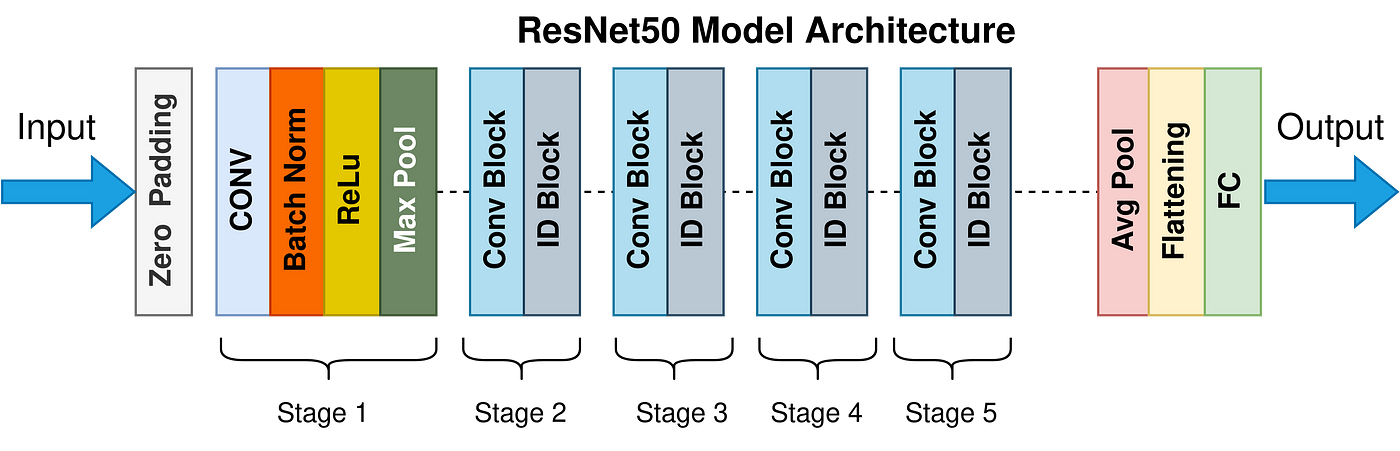

In [ ]:
Image(filename='/content/resnet.png')

# **1.C Advantages and Disadvantages of Data Augmentation**



### Advantages of Data Augmentation

1. **Enhanced Model Generalization**: Data augmentation improves the model's ability to generalize by exposing it to a diverse range of variations, leading to better performance on unseen data.

2. **Increased Dataset Size**: It artificially enlarges the dataset, which helps in preventing overfitting and improving the robustness of the model.

3. **Improved Accuracy**: By training on augmented data, models can achieve higher accuracy rates as they learn to recognize patterns in different scenarios.

4. **Reduced Need for Manual Efforts**: Automates the creation of diverse training examples, reducing the need for extensive manual preprocessing and feature engineering.

5. **Better Noise Robustness**: Models trained with augmented data are more resilient to noise and minor distortions in images, enhancing their reliability in real-world applications.

### Disadvantages of Data Augmentation

1. **Increased Computational Load**: The process of generating and training on augmented data demands significant computational resources, increasing the training time and memory requirements.

2. **Limited Effectiveness on Small Datasets**: While it can help, data augmentation alone cannot fully address the issues of overfitting in very small datasets, as the inherent data variety remains limited.

3. **Vulnerability to Tricks**: Even with augmented data, models can still be fooled by slight changes designed to trick them, known as adversarial attacks.

4. **Potential for Overfitting to Augmentations**: There's a risk that the model may overfit to the augmented variations rather than learning more general features, which can limit its ability to generalize beyond the specific types of augmentations used.

In summary, data augmentation is a powerful technique to enhance model performance, but it must be applied carefully to balance its benefits against the increased computational demands and potential limitations.

# **Part II**

# **2.A Deep Convolutional Generative Adversarial Network (DCGAN) for CIFAR-10 Dataset**

Define constants

In [ ]:
BUFFER_SIZE = 5000
BATCH_SIZE = 128
noise_dim = 100
img_rows, img_cols, channels = 32, 32, 3
EPOCHS = 200

Load and Preprocess Data

The following function loads the CIFAR-10 dataset, but only selects images of a specific class (e.g., cars). It also normalizes the images to have values between -1 and 1, which helps the model learn more effectively.

In [ ]:
def load_real_samples(BUFFER_SIZE: int, BATCH_SIZE: int):
    (X_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()
    X_train = X_train[np.where(y_train == 1)[0]]
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, channels).astype('float32')
    X_train = (X_train - 127.5) / 127.5

    dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)
    return X_train, dataset


Define the Generator Model

The generator model creates new images from random noise. It takes a random vector (a sequence of numbers) and transforms it step by step into a full image.


In [ ]:
def define_generator(noise_dim: int) -> Sequential:
    model = Sequential()
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=noise_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Reshape((4, 4, 256)))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
    return model

 Define the Discriminator Model

The discriminator model evaluates whether an image is real (from the dataset) or fake (generated by the generator). It outputs a single value indicating the likelihood that the image is real.

In [ ]:
def define_discriminator(in_shape=(32,32,3)) -> Sequential:
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

Combine Generator and Discriminator into a GAN

The GAN combines the generator and discriminator. It ensures that when the generator creates an image, the discriminator evaluates it. During training, only the generator's weights are updated.

In [ ]:
def define_gan(g_model: Sequential, d_model: Sequential) -> Sequential:
    d_model.trainable = False
    model = Sequential([g_model, d_model])
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

Function to generate images based on noise

In [ ]:
def generation_images(BATCH_SIZE: int, noise_dim: int, generator: Sequential) -> tf.Tensor:
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    generated_image = generator(noise, training=True)
    return generated_image

Function to generate and save images

In [ ]:
def generate_and_save_images(static_noise: tf.Tensor, epoch: int, generator: Sequential):
    generated_images = generator(static_noise, training=False)
    plt.figure(figsize=(10, 10))
    for i in range(6*6):
        plt.subplot(6, 6, i+1)
        plt.imshow((generated_images[i] * 127.5 + 127.5).numpy().astype("uint8"))
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1))
    plt.show()

Train the GAN

The training function runs through many iterations (epochs), generating images and updating the models. It trains the discriminator on both real and fake images, then trains the GAN to improve the generator.

In [ ]:
def train_model(EPOCHS: int, BATCH_SIZE: int, X_train: np.ndarray, dataset, noise_dim: int, static_noise: tf.Tensor, model: Sequential):
    generator, discriminator = model.layers

    for epoch in range(EPOCHS):
        print(f"Currently on Epoch {epoch+1}")
        i = 0
        for X_batch in dataset:
            i += 1
            if i % 100 == 0:
                print(f"\tCurrently on batch number {i} of {len(X_train) // BATCH_SIZE}")

            gen_images = generation_images(BATCH_SIZE, noise_dim, generator)
            X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch, tf.float32)], axis=0)
            y1 = tf.constant([[0.]] * BATCH_SIZE + [[0.9]] * BATCH_SIZE)
            d_loss = discriminator.train_on_batch(X_fake_vs_real, y1)

            noise = tf.random.normal(shape=[BATCH_SIZE, noise_dim])
            y2 = tf.constant([[1.]] * BATCH_SIZE)
            g_loss = model.train_on_batch(noise, y2)

        # Save image every 5 epochs
        if (epoch+1) % 5 == 0:
            print(f'\tDiscriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
            generate_and_save_images(static_noise, epoch, generator)
        # Save model every 50 epochs
        if (epoch+1) % 50 == 0:
            filename = 'generator_cars_model_%03d.h5' % (epoch+1)
            generator.save(filename)


170498071/170498071 [==============================] - 4s 0us/step
Currently on Epoch 1
Currently on Epoch 2
Currently on Epoch 3
Currently on Epoch 4
Currently on Epoch 5
	Discriminator Loss: [0.4930245280265808, 0.453125] 		 Generator Loss: 1.4235259294509888


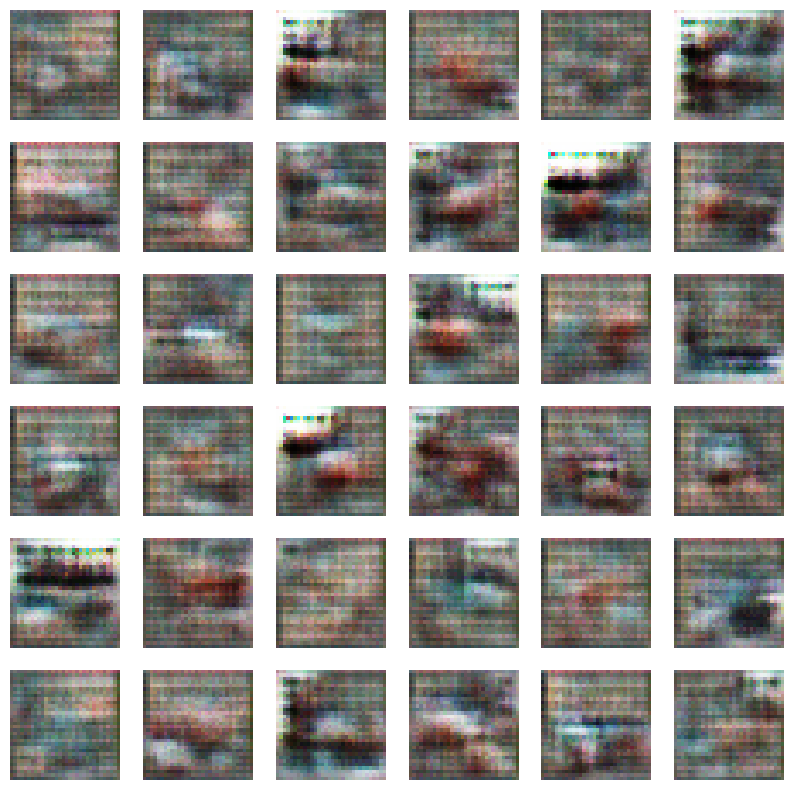

Currently on Epoch 6
Currently on Epoch 7
Currently on Epoch 8
Currently on Epoch 9
Currently on Epoch 10
	Discriminator Loss: [0.5647178292274475, 0.26171875] 		 Generator Loss: 2.6521098613739014


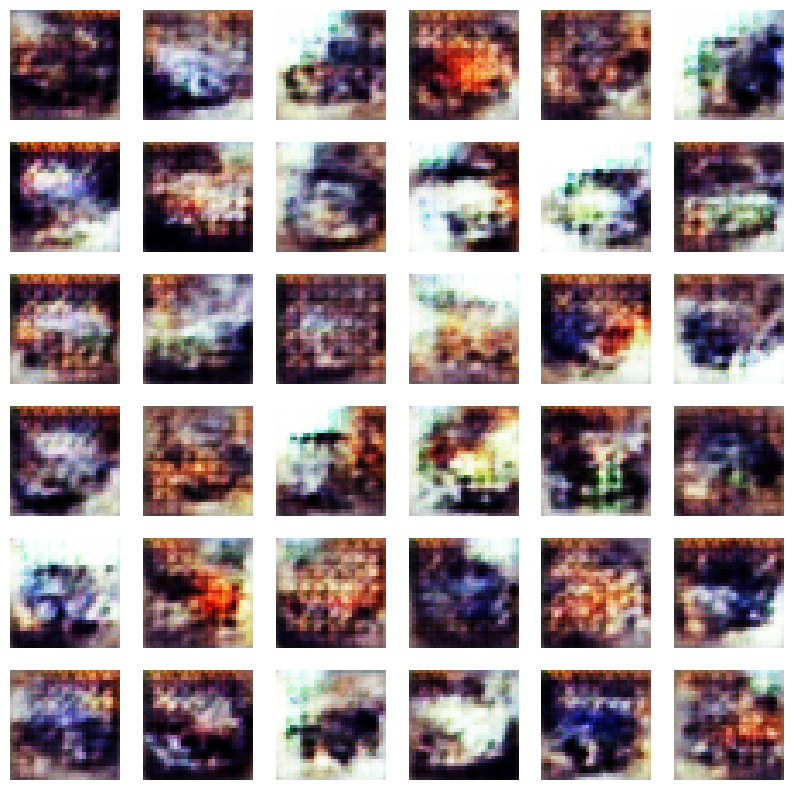

Currently on Epoch 11
Currently on Epoch 12
Currently on Epoch 13
Currently on Epoch 14
Currently on Epoch 15
	Discriminator Loss: [0.4134596586227417, 0.49609375] 		 Generator Loss: 1.8469905853271484


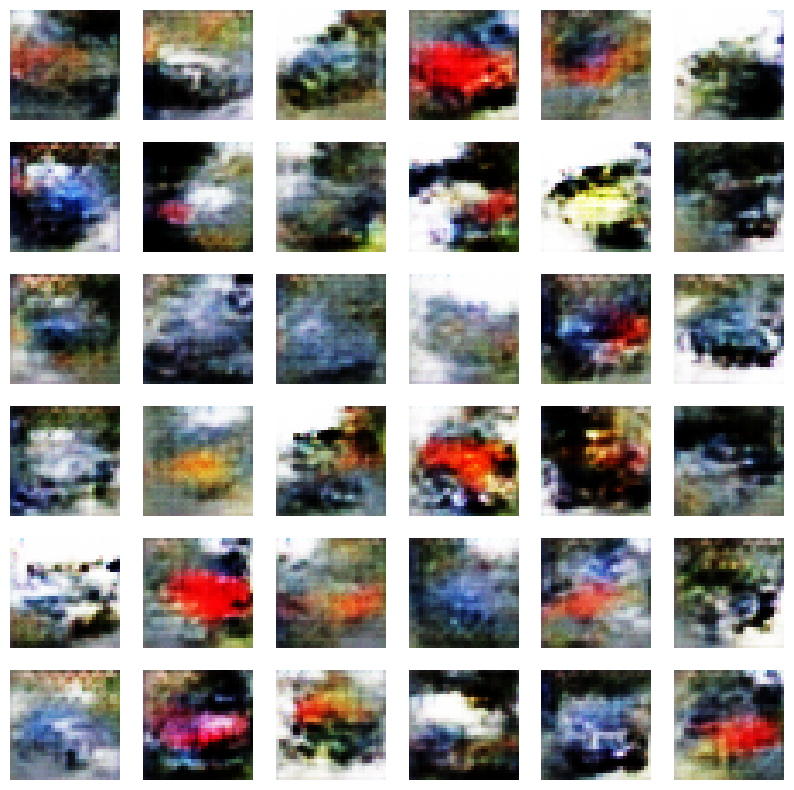

Currently on Epoch 16
Currently on Epoch 17
Currently on Epoch 18
Currently on Epoch 19
Currently on Epoch 20
	Discriminator Loss: [0.2849970757961273, 0.5] 		 Generator Loss: 2.0841965675354004


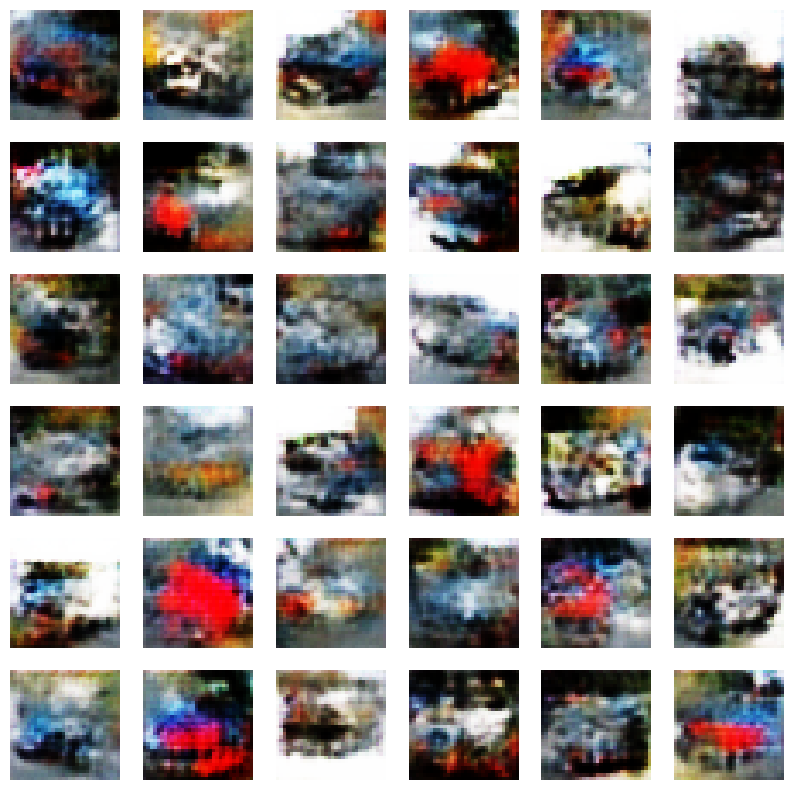

Currently on Epoch 21
Currently on Epoch 22
Currently on Epoch 23
Currently on Epoch 24
Currently on Epoch 25
	Discriminator Loss: [0.7130800485610962, 0.4765625] 		 Generator Loss: 0.7715323567390442


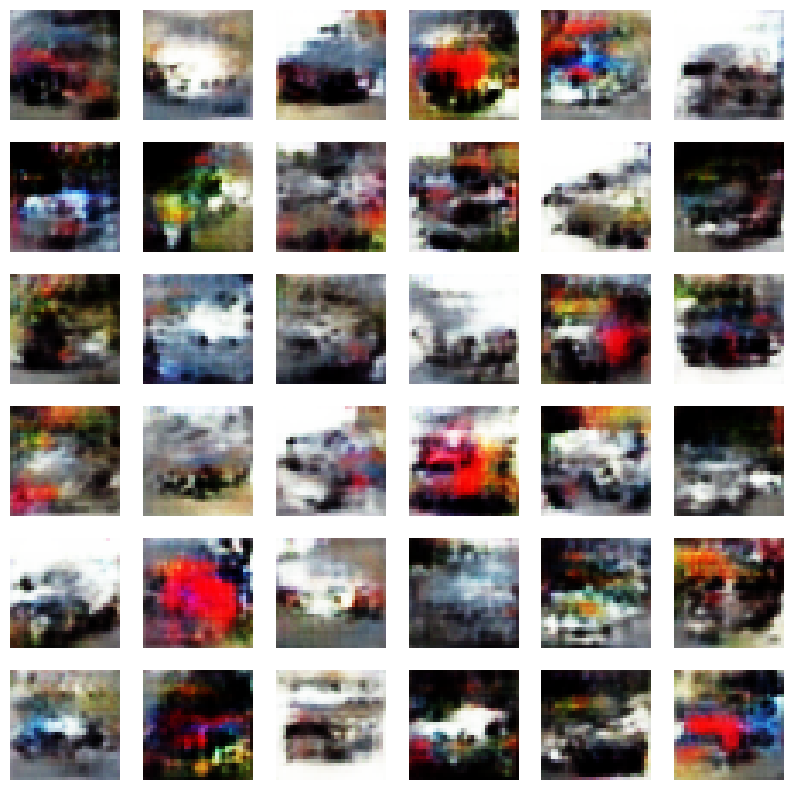

Currently on Epoch 26
Currently on Epoch 27
Currently on Epoch 28
Currently on Epoch 29
Currently on Epoch 30
	Discriminator Loss: [0.502761721611023, 0.4453125] 		 Generator Loss: 1.856499195098877


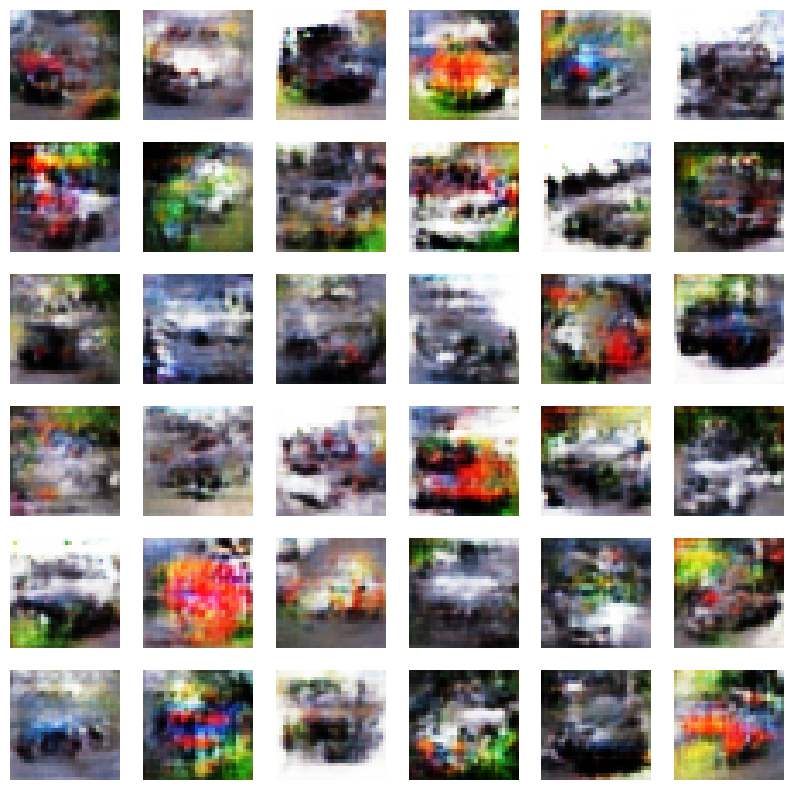

Currently on Epoch 31
Currently on Epoch 32
Currently on Epoch 33
Currently on Epoch 34
Currently on Epoch 35
	Discriminator Loss: [0.3463094234466553, 0.48046875] 		 Generator Loss: 3.4159812927246094


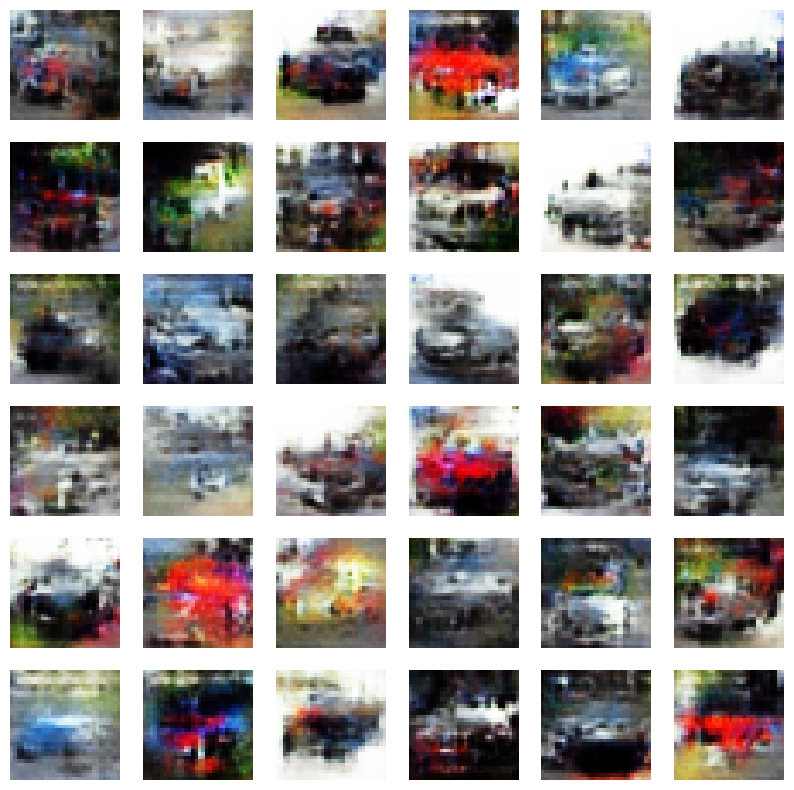

Currently on Epoch 36
Currently on Epoch 37
Currently on Epoch 38
Currently on Epoch 39
Currently on Epoch 40
	Discriminator Loss: [0.3628598749637604, 0.5] 		 Generator Loss: 2.591618061065674


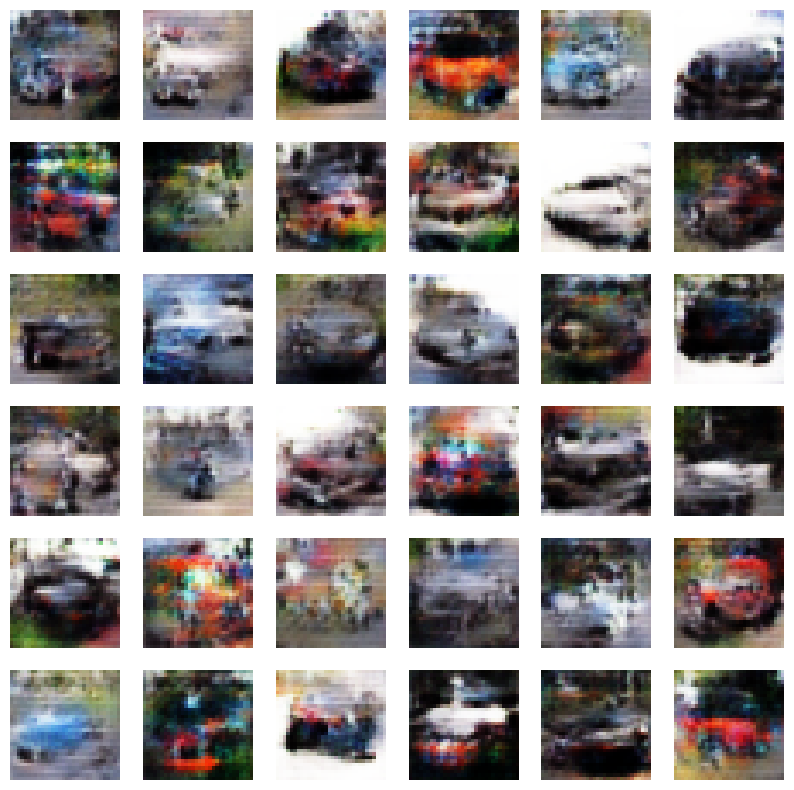

Currently on Epoch 41
Currently on Epoch 42
Currently on Epoch 43
Currently on Epoch 44
Currently on Epoch 45
	Discriminator Loss: [0.3733005225658417, 0.47265625] 		 Generator Loss: 2.966970443725586


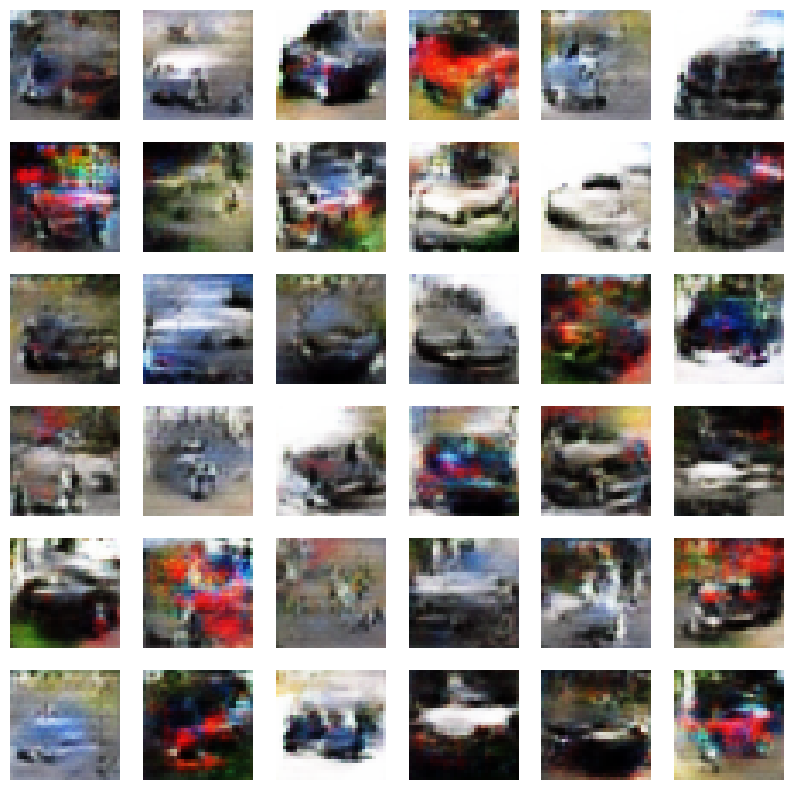

Currently on Epoch 46
Currently on Epoch 47
Currently on Epoch 48
Currently on Epoch 49
Currently on Epoch 50
	Discriminator Loss: [0.49616867303848267, 0.359375] 		 Generator Loss: 2.845196485519409


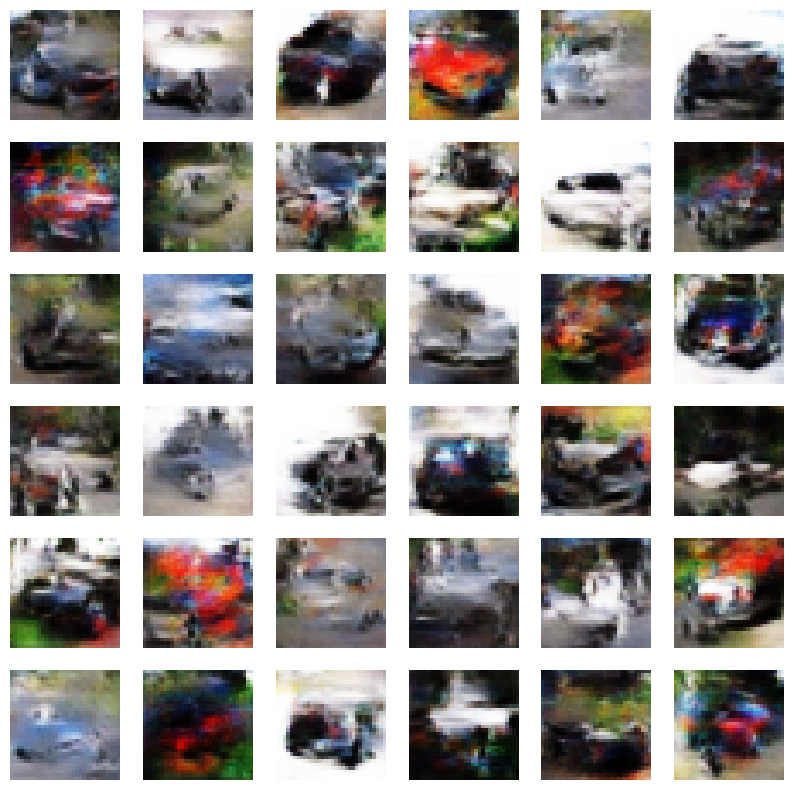

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Currently on Epoch 51
Currently on Epoch 52
Currently on Epoch 53
Currently on Epoch 54
Currently on Epoch 55
	Discriminator Loss: [0.4213513433933258, 0.4765625] 		 Generator Loss: 1.846848487854004


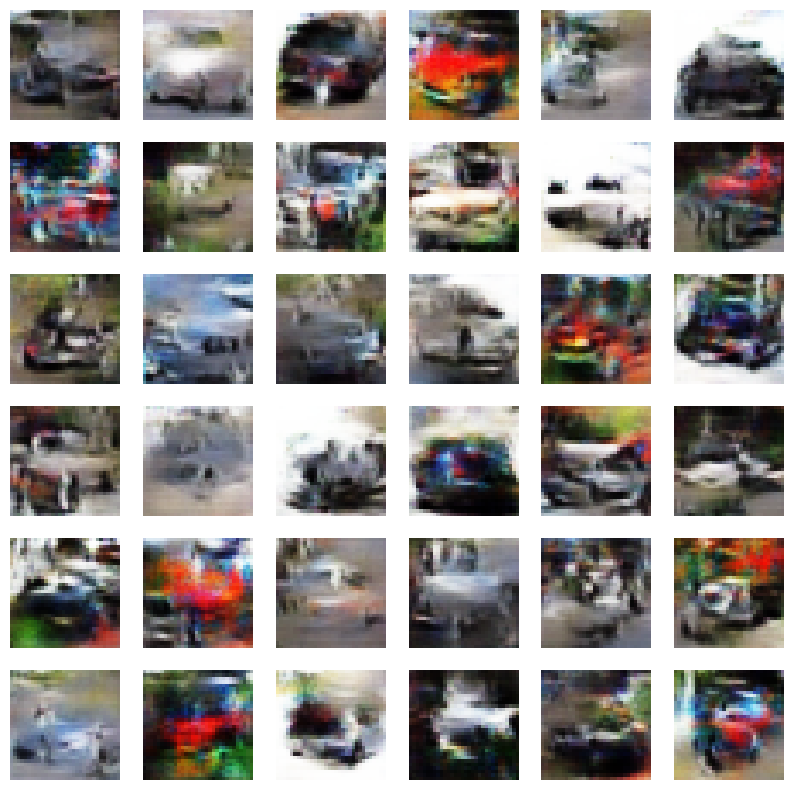

Currently on Epoch 56
Currently on Epoch 57
Currently on Epoch 58
Currently on Epoch 59
Currently on Epoch 60
	Discriminator Loss: [0.344746470451355, 0.484375] 		 Generator Loss: 2.6764347553253174


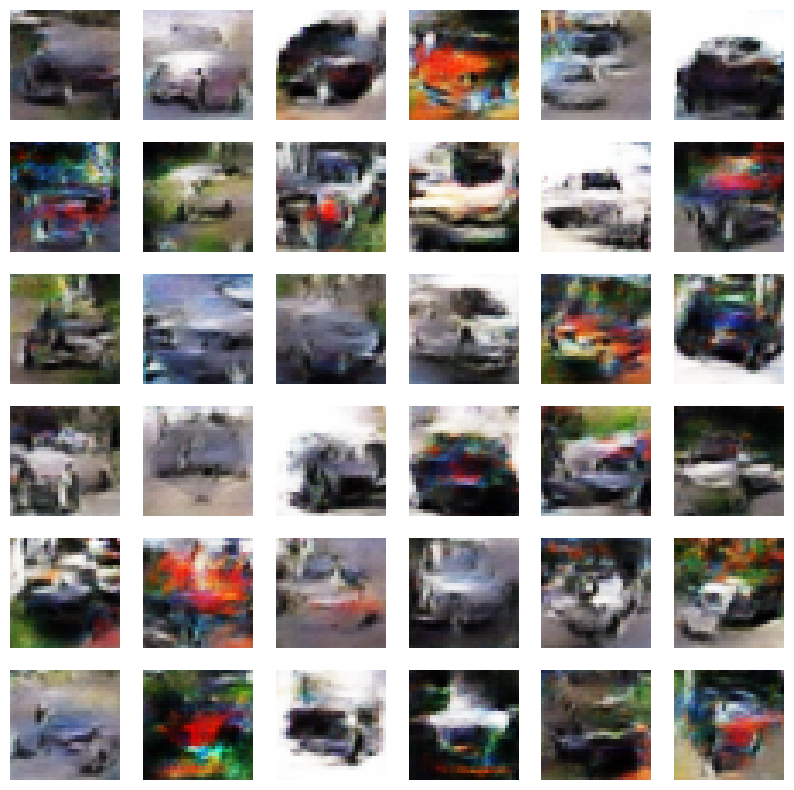

Currently on Epoch 61
Currently on Epoch 62
Currently on Epoch 63
Currently on Epoch 64
Currently on Epoch 65
	Discriminator Loss: [0.6097051501274109, 0.3828125] 		 Generator Loss: 1.4752421379089355


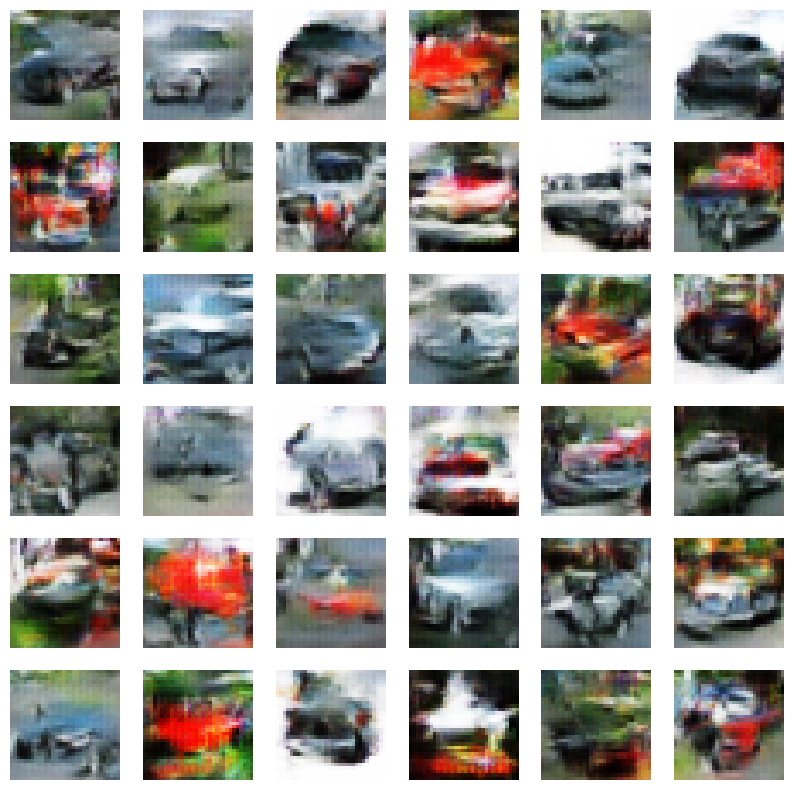

Currently on Epoch 66
Currently on Epoch 67
Currently on Epoch 68
Currently on Epoch 69
Currently on Epoch 70
	Discriminator Loss: [0.4040737748146057, 0.4921875] 		 Generator Loss: 1.9847412109375


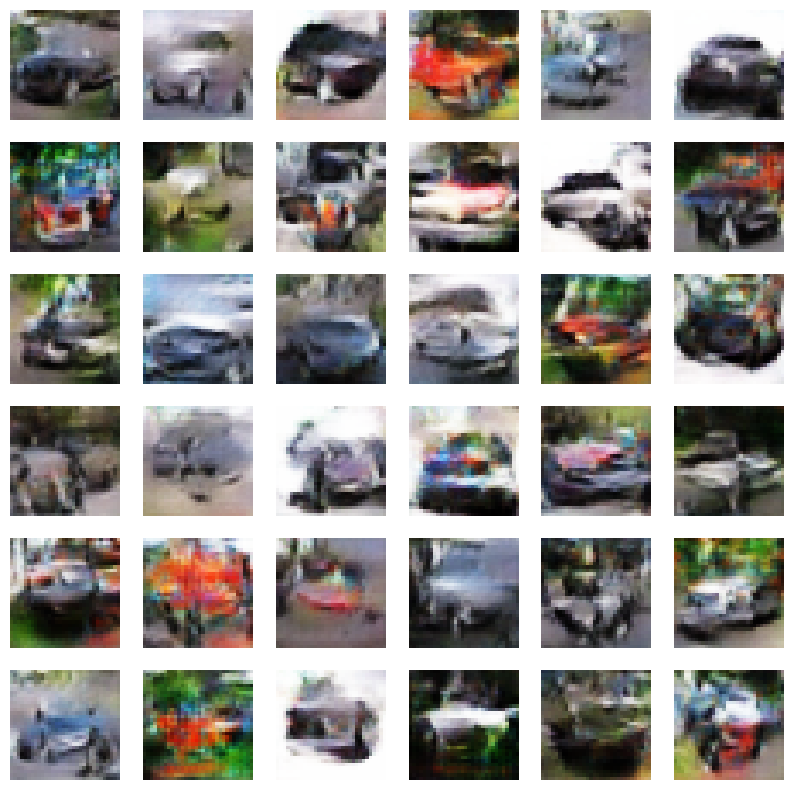

Currently on Epoch 71
Currently on Epoch 72
Currently on Epoch 73
Currently on Epoch 74
Currently on Epoch 75
	Discriminator Loss: [0.3530416488647461, 0.484375] 		 Generator Loss: 2.5107192993164062


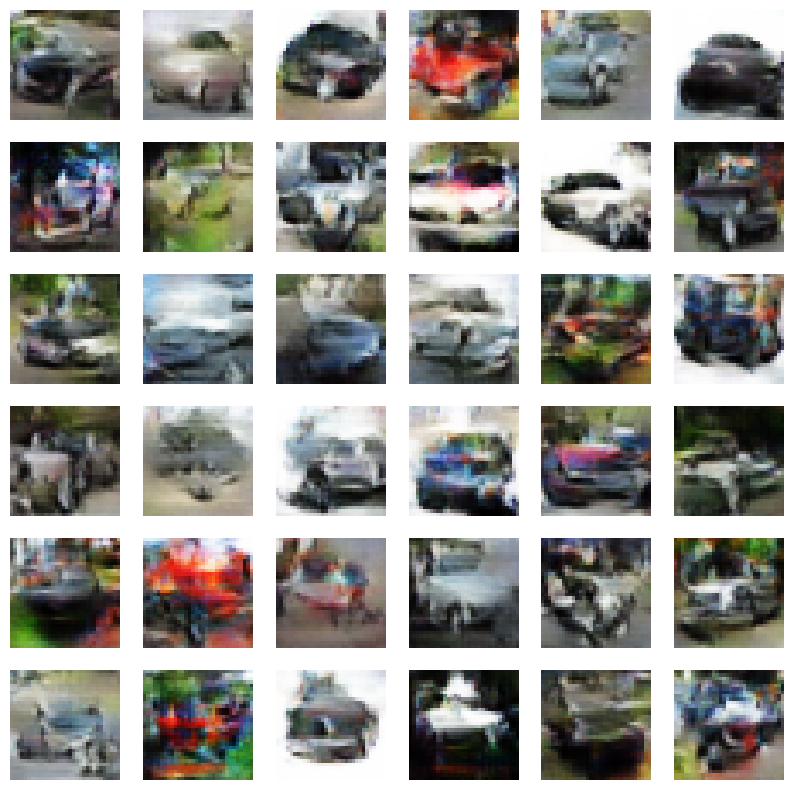

Currently on Epoch 76
Currently on Epoch 77
Currently on Epoch 78
Currently on Epoch 79
Currently on Epoch 80
	Discriminator Loss: [0.3610498309135437, 0.49609375] 		 Generator Loss: 2.1856791973114014


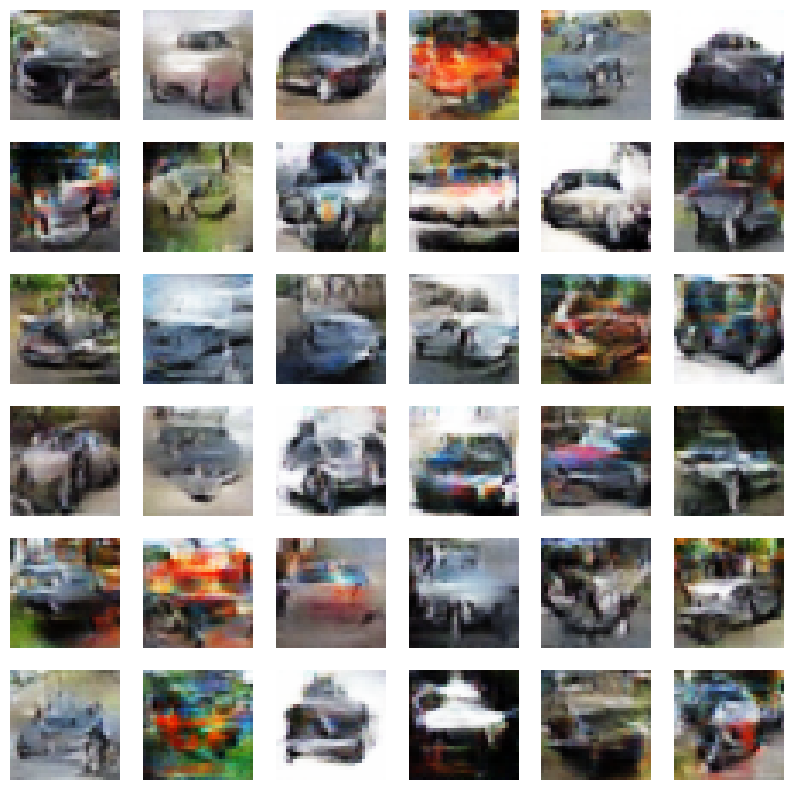

Currently on Epoch 81
Currently on Epoch 82
Currently on Epoch 83
Currently on Epoch 84
Currently on Epoch 85
	Discriminator Loss: [0.31391361355781555, 0.4921875] 		 Generator Loss: 2.7824485301971436


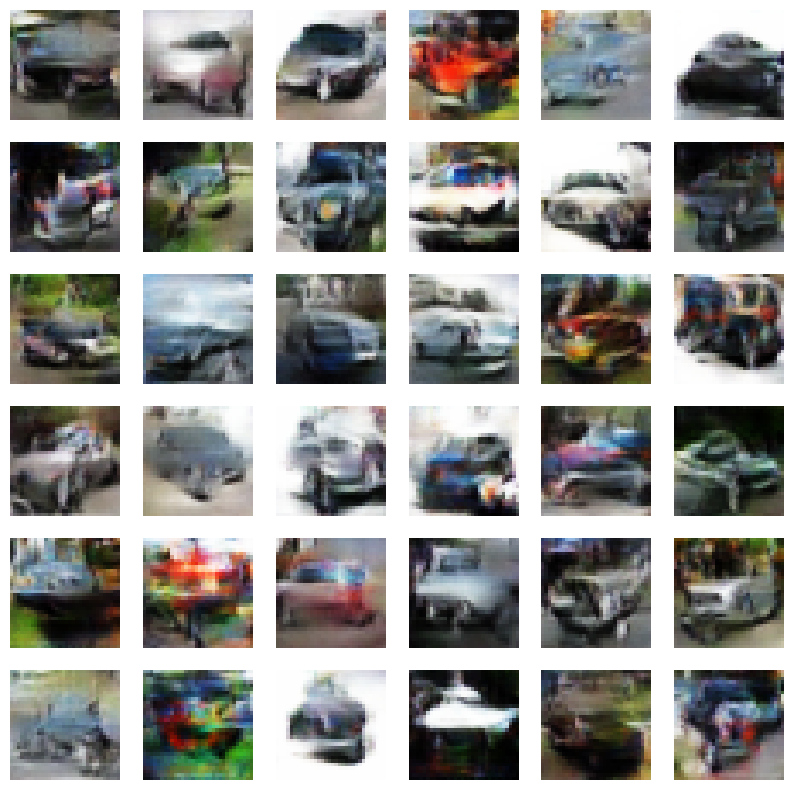

Currently on Epoch 86
Currently on Epoch 87
Currently on Epoch 88
Currently on Epoch 89
Currently on Epoch 90
	Discriminator Loss: [0.42518526315689087, 0.41015625] 		 Generator Loss: 3.208043336868286


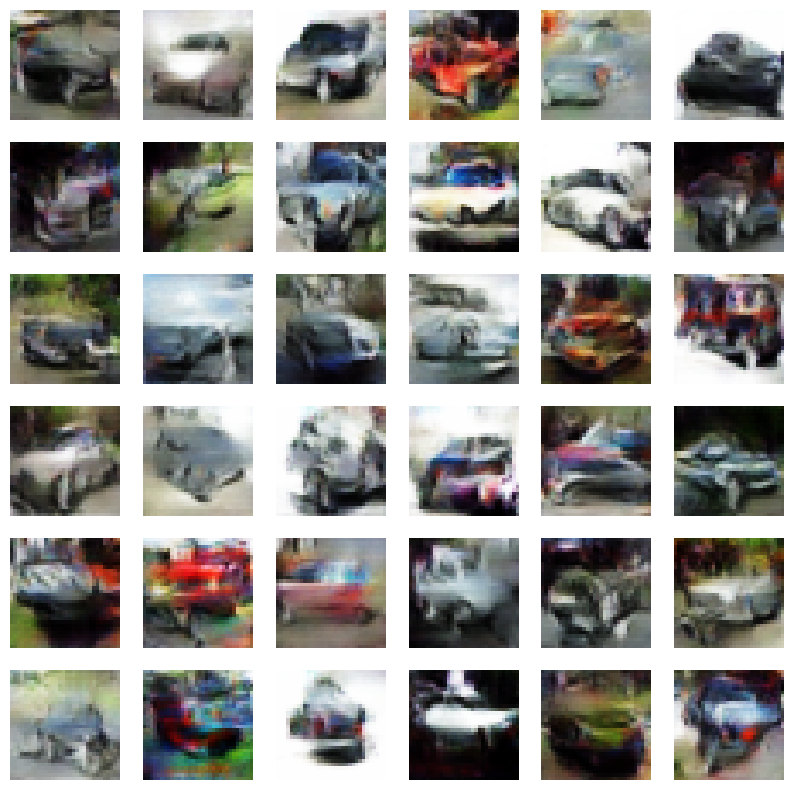

Currently on Epoch 91
Currently on Epoch 92
Currently on Epoch 93
Currently on Epoch 94
Currently on Epoch 95
	Discriminator Loss: [0.3530835211277008, 0.47265625] 		 Generator Loss: 2.589306116104126


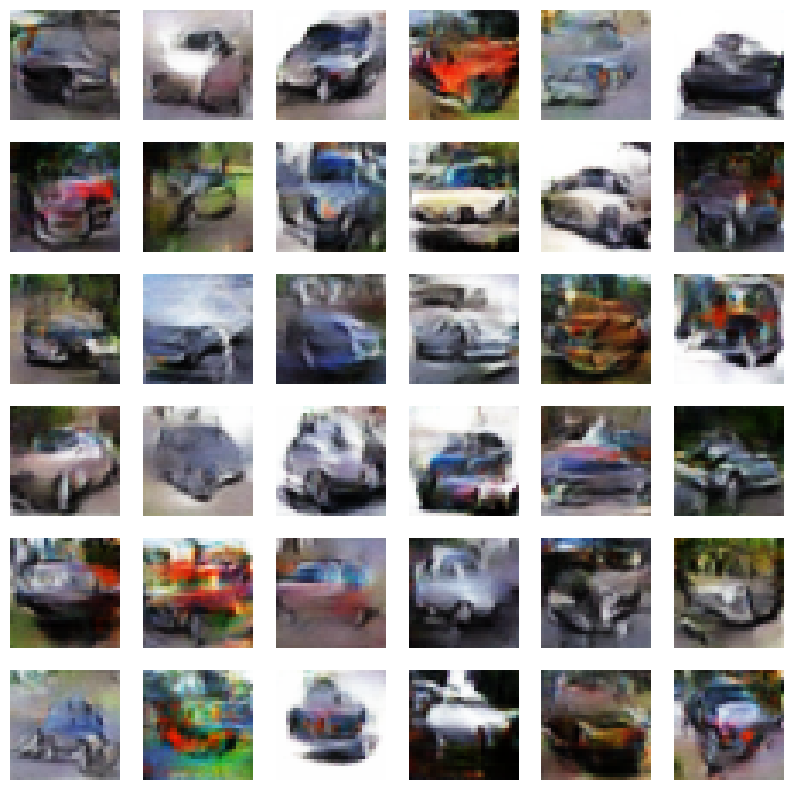

Currently on Epoch 96
Currently on Epoch 97
Currently on Epoch 98
Currently on Epoch 99
Currently on Epoch 100
	Discriminator Loss: [0.3159608244895935, 0.46875] 		 Generator Loss: 3.8538918495178223


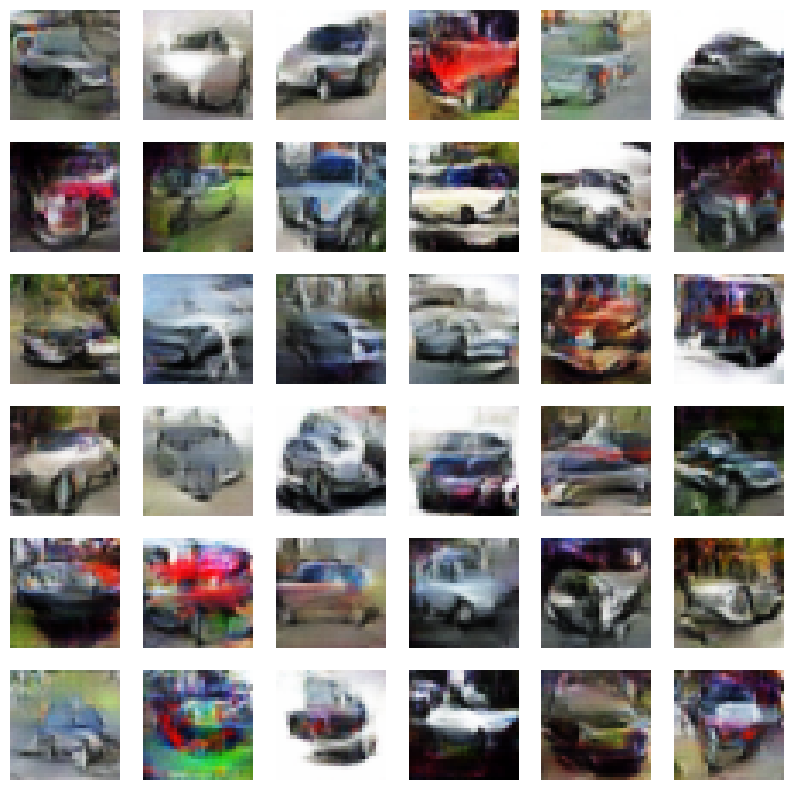

Currently on Epoch 101
Currently on Epoch 102
Currently on Epoch 103
Currently on Epoch 104
Currently on Epoch 105
	Discriminator Loss: [0.5349048376083374, 0.33203125] 		 Generator Loss: 3.4732346534729004


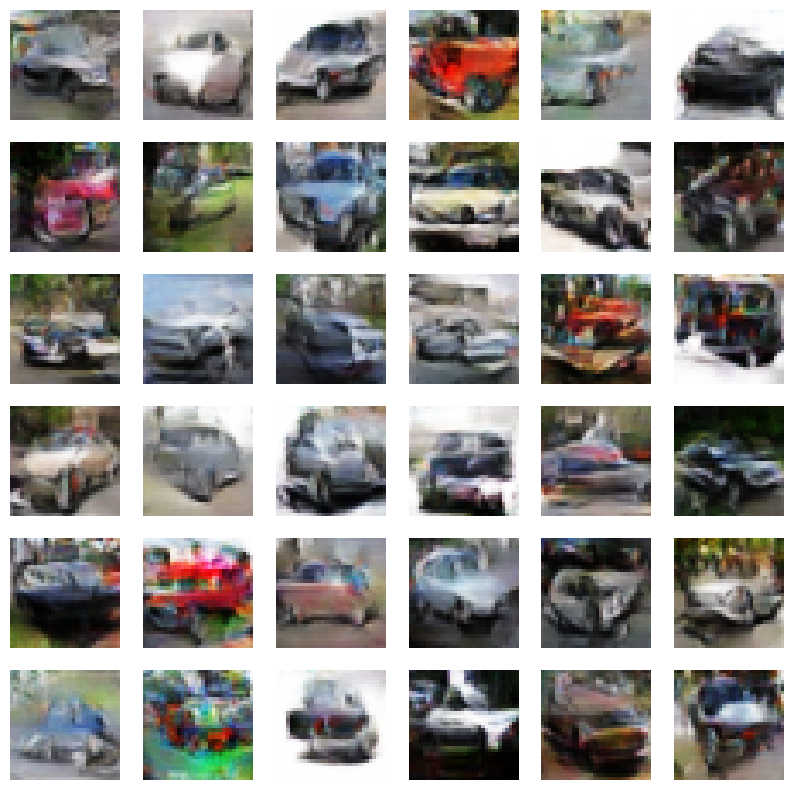

Currently on Epoch 106
Currently on Epoch 107
Currently on Epoch 108
Currently on Epoch 109
Currently on Epoch 110
	Discriminator Loss: [0.4883885979652405, 0.4375] 		 Generator Loss: 2.0006208419799805


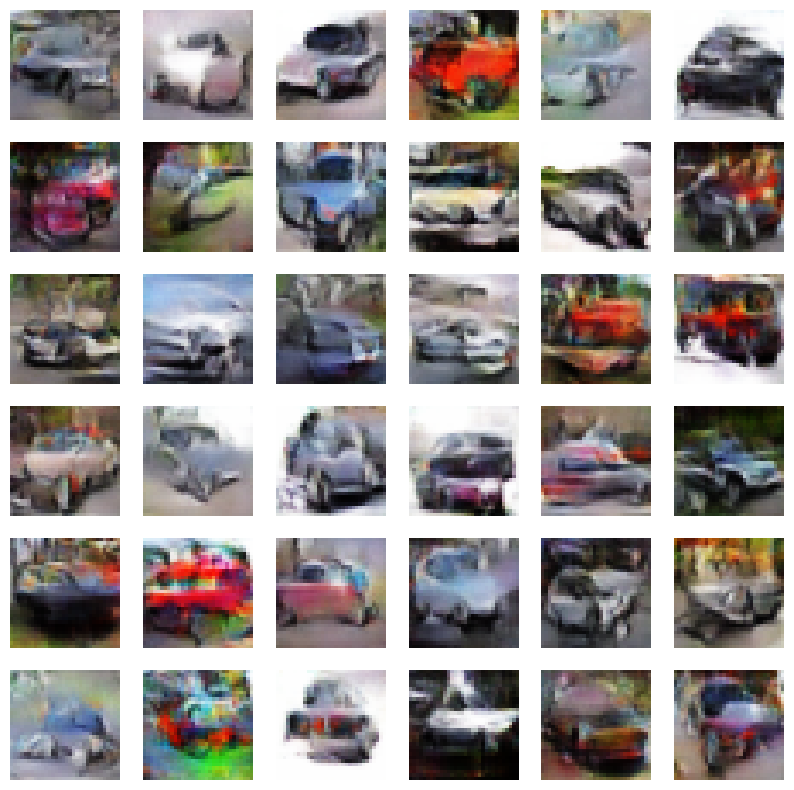

Currently on Epoch 111
Currently on Epoch 112
Currently on Epoch 113
Currently on Epoch 114
Currently on Epoch 115
	Discriminator Loss: [0.38111910223960876, 0.46875] 		 Generator Loss: 2.1858630180358887


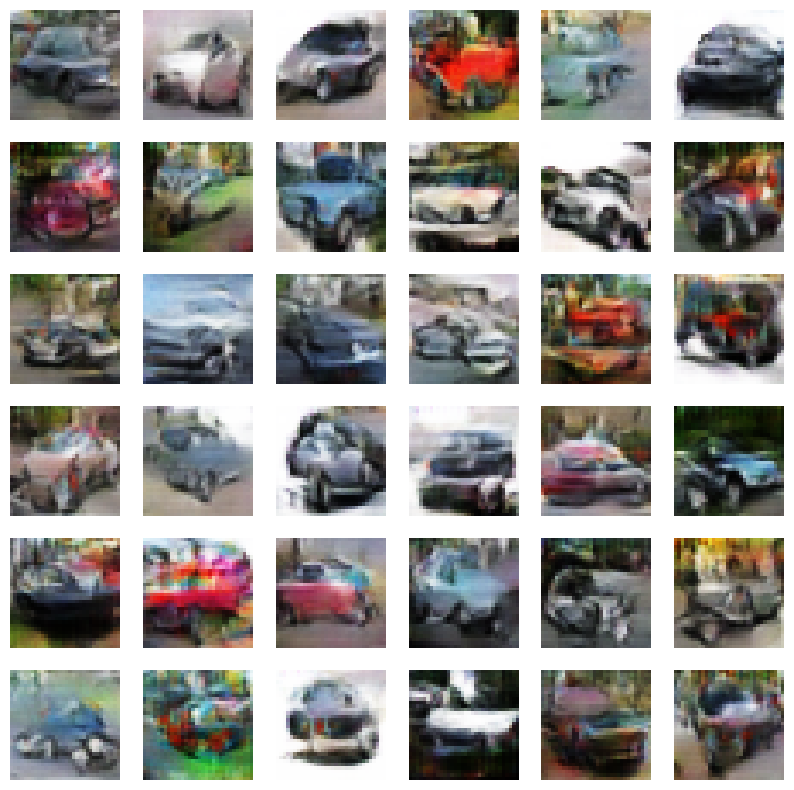

Currently on Epoch 116
Currently on Epoch 117
Currently on Epoch 118
Currently on Epoch 119
Currently on Epoch 120
	Discriminator Loss: [0.37744688987731934, 0.45703125] 		 Generator Loss: 2.609926700592041


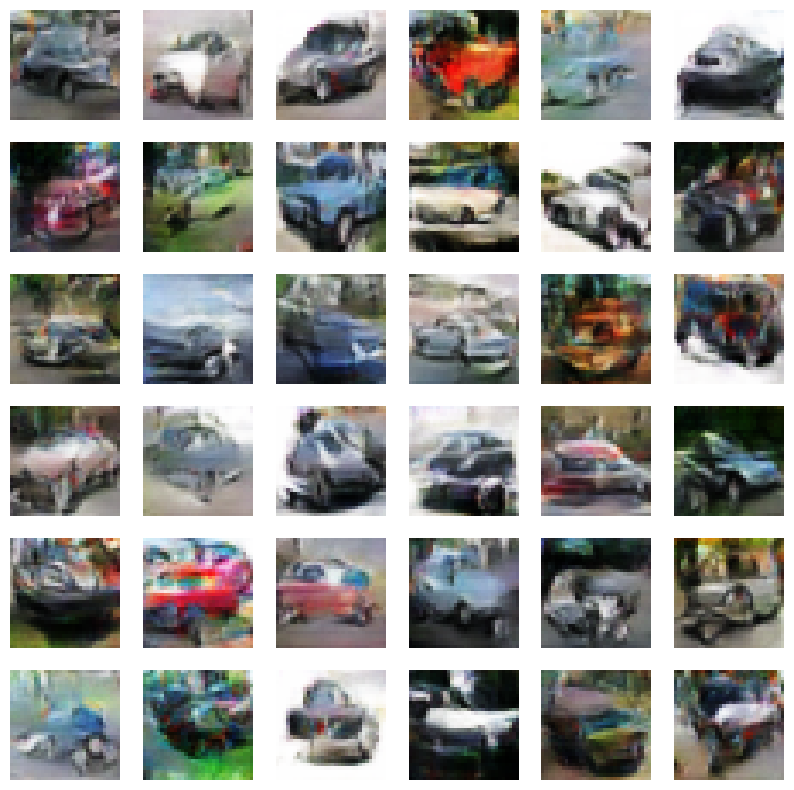

Currently on Epoch 121
Currently on Epoch 122
Currently on Epoch 123
Currently on Epoch 124
Currently on Epoch 125
	Discriminator Loss: [0.37838488817214966, 0.49609375] 		 Generator Loss: 2.306739330291748


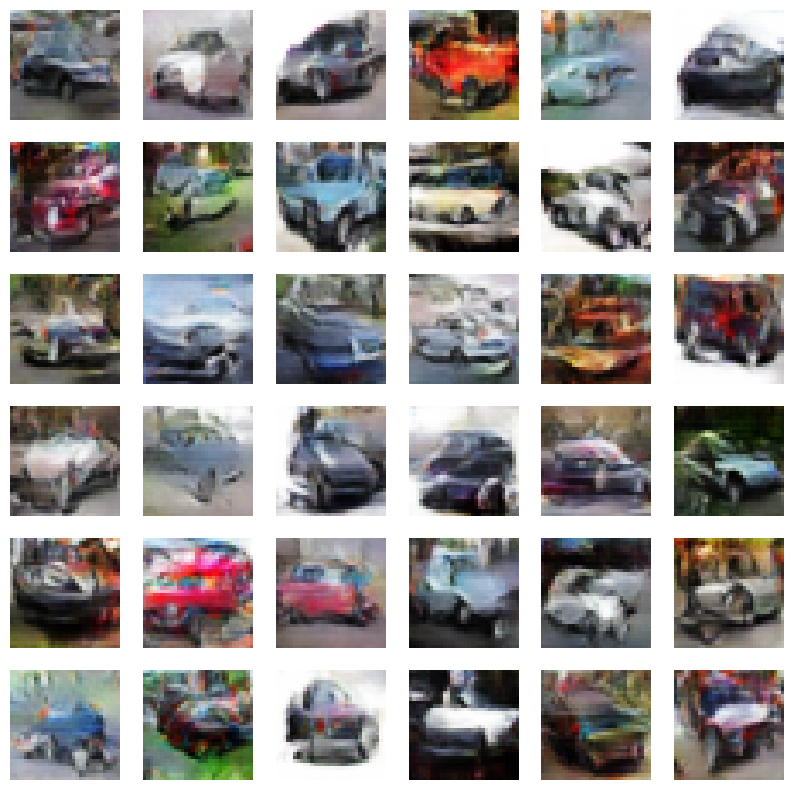

Currently on Epoch 126
Currently on Epoch 127
Currently on Epoch 128
Currently on Epoch 129
Currently on Epoch 130
	Discriminator Loss: [0.44614899158477783, 0.5] 		 Generator Loss: 1.6277015209197998


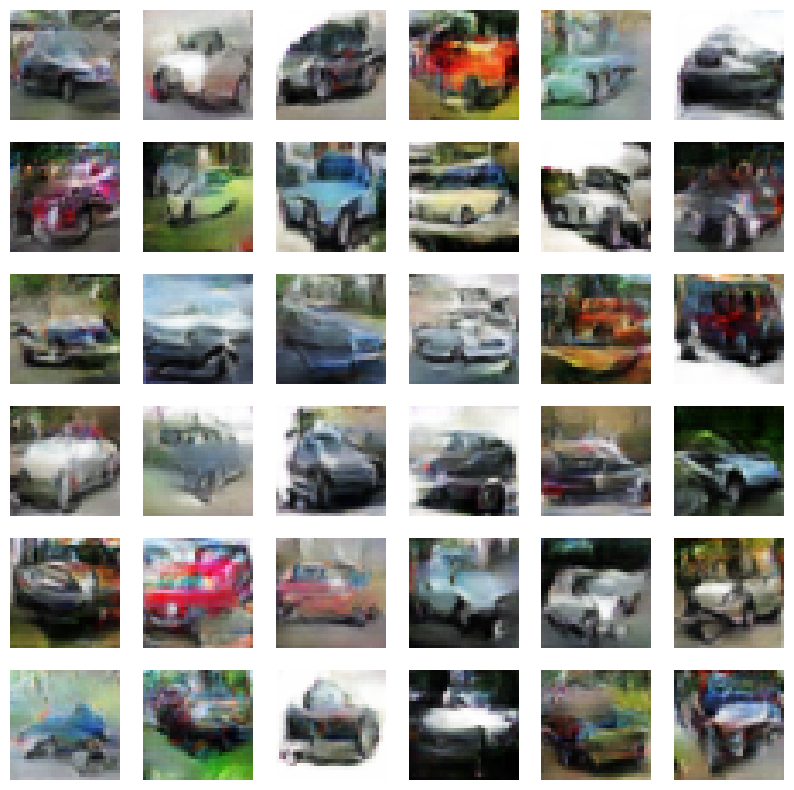

Currently on Epoch 131
Currently on Epoch 132
Currently on Epoch 133
Currently on Epoch 134
Currently on Epoch 135
	Discriminator Loss: [0.3276495933532715, 0.484375] 		 Generator Loss: 3.2582826614379883


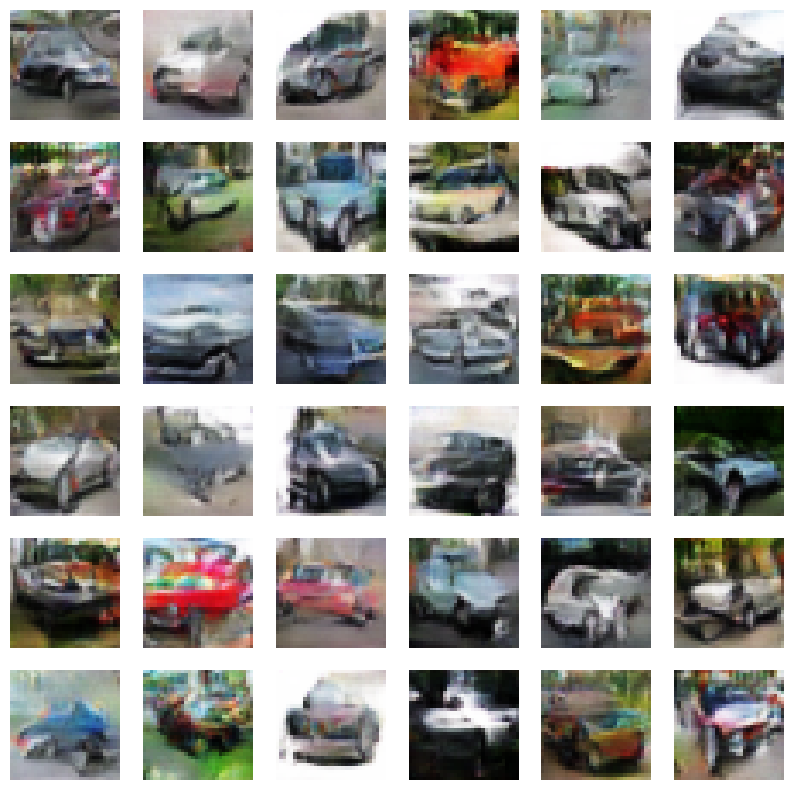

Currently on Epoch 136
Currently on Epoch 137
Currently on Epoch 138
Currently on Epoch 139
Currently on Epoch 140
	Discriminator Loss: [0.3160516023635864, 0.49609375] 		 Generator Loss: 2.613913059234619


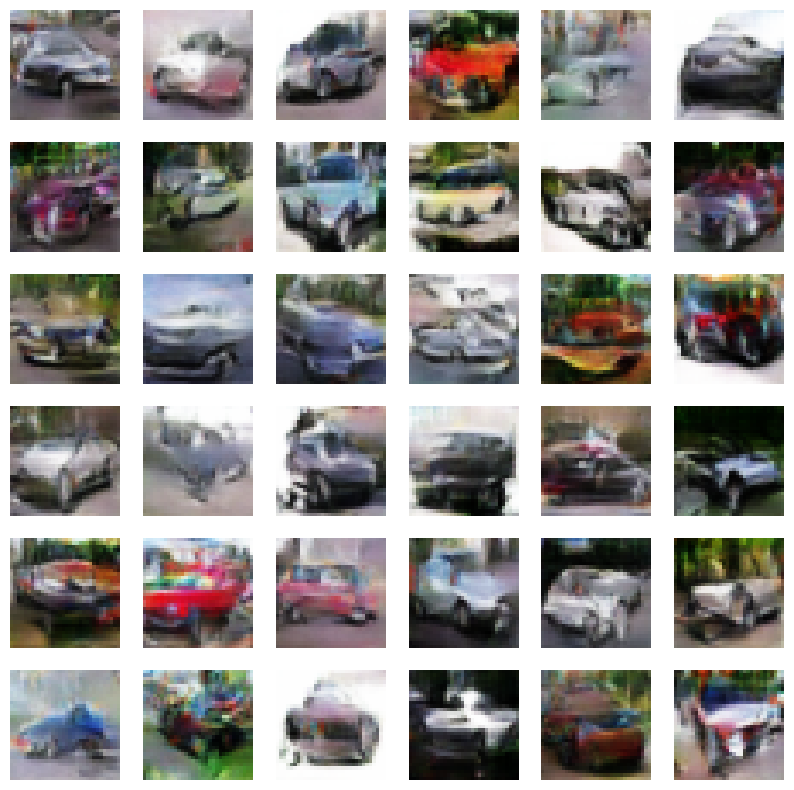

Currently on Epoch 141
Currently on Epoch 142
Currently on Epoch 143
Currently on Epoch 144
Currently on Epoch 145
	Discriminator Loss: [0.3335080146789551, 0.4921875] 		 Generator Loss: 2.5425586700439453


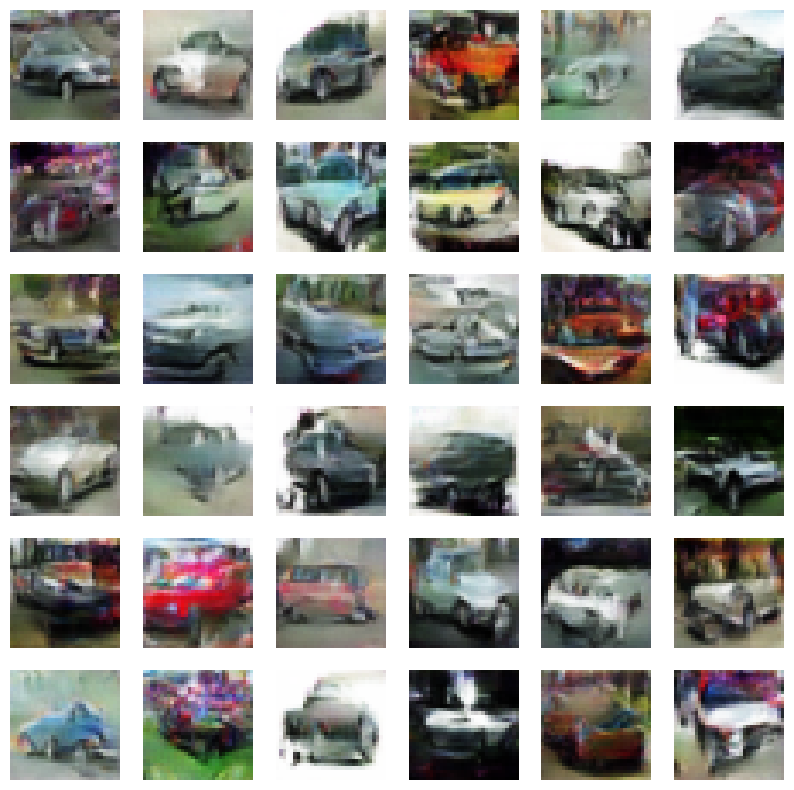

Currently on Epoch 146
Currently on Epoch 147
Currently on Epoch 148
Currently on Epoch 149
Currently on Epoch 150
	Discriminator Loss: [0.29985877871513367, 0.48828125] 		 Generator Loss: 3.382340908050537


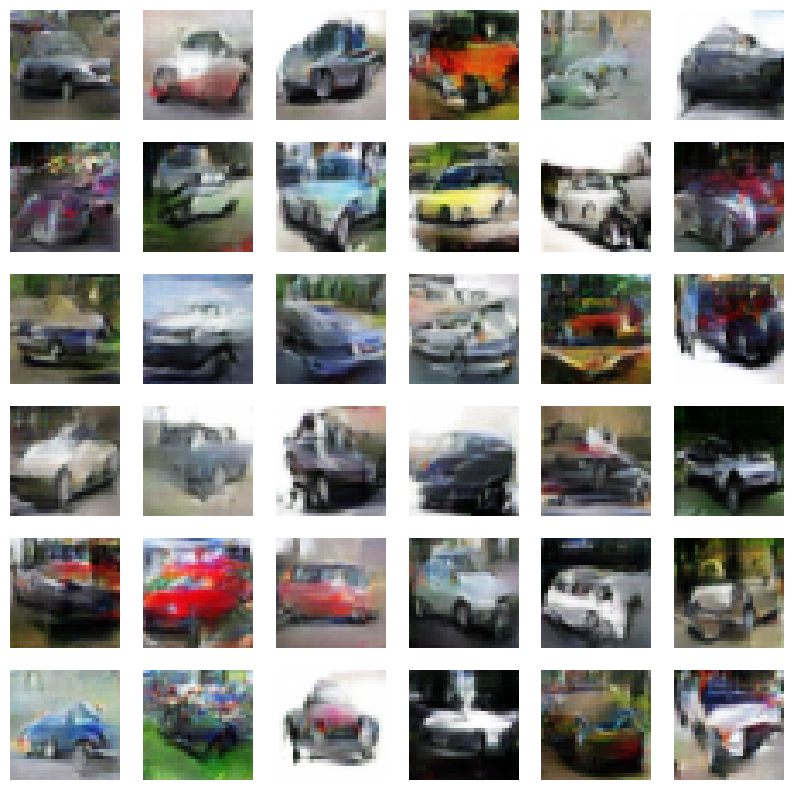

Currently on Epoch 151
Currently on Epoch 152
Currently on Epoch 153
Currently on Epoch 154
Currently on Epoch 155
	Discriminator Loss: [0.2832963466644287, 0.49609375] 		 Generator Loss: 3.346071720123291


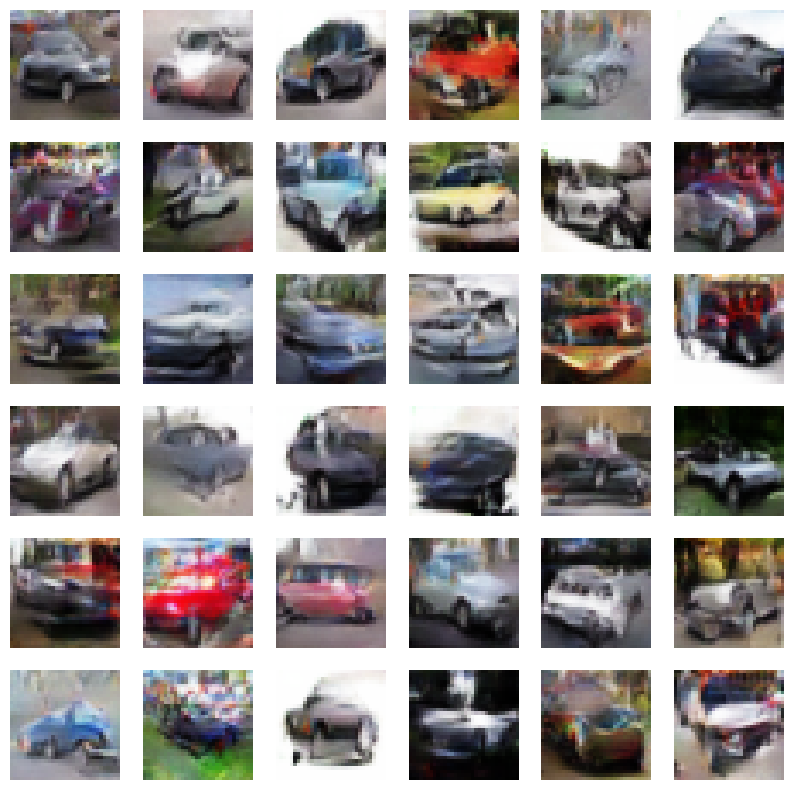

Currently on Epoch 156
Currently on Epoch 157
Currently on Epoch 158
Currently on Epoch 159
Currently on Epoch 160
	Discriminator Loss: [0.2790784537792206, 0.5] 		 Generator Loss: 3.389583110809326


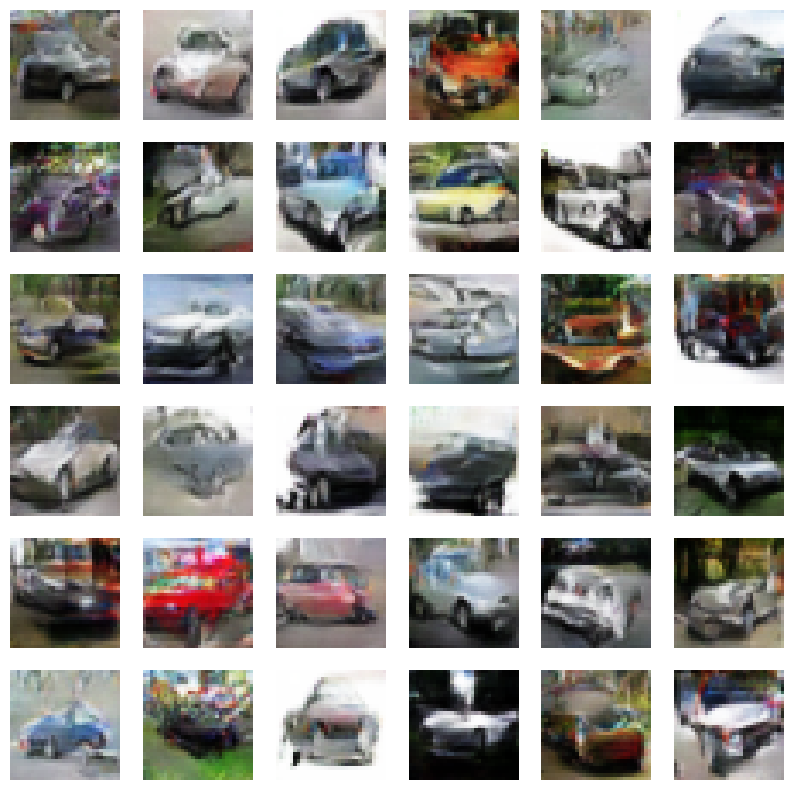

Currently on Epoch 161
Currently on Epoch 162
Currently on Epoch 163
Currently on Epoch 164
Currently on Epoch 165
	Discriminator Loss: [0.2866891622543335, 0.4921875] 		 Generator Loss: 3.012385606765747


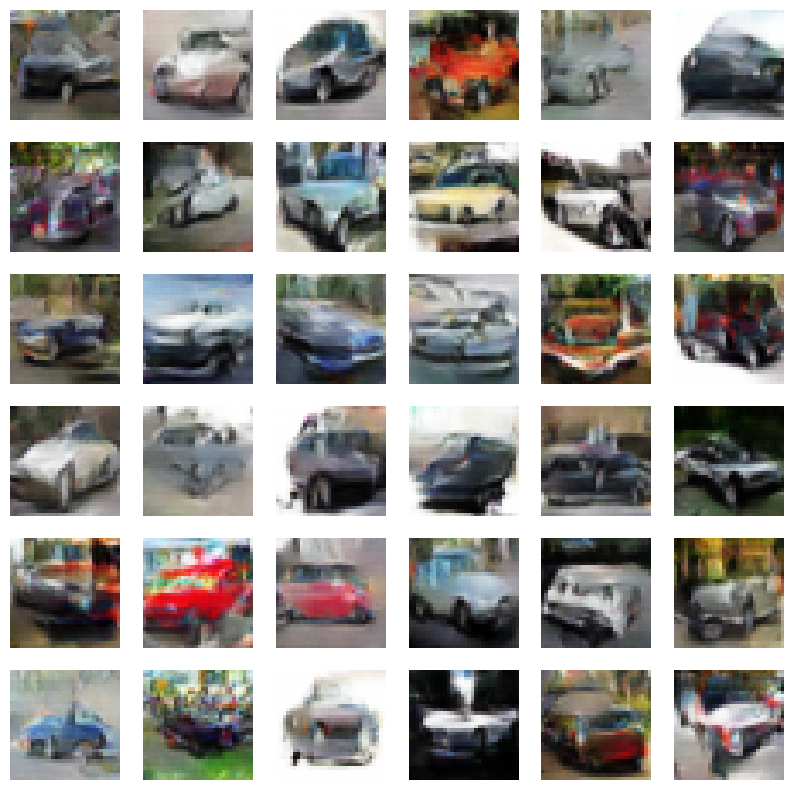

Currently on Epoch 166
Currently on Epoch 167
Currently on Epoch 168
Currently on Epoch 169
Currently on Epoch 170
	Discriminator Loss: [0.40690407156944275, 0.42578125] 		 Generator Loss: 2.906949996948242


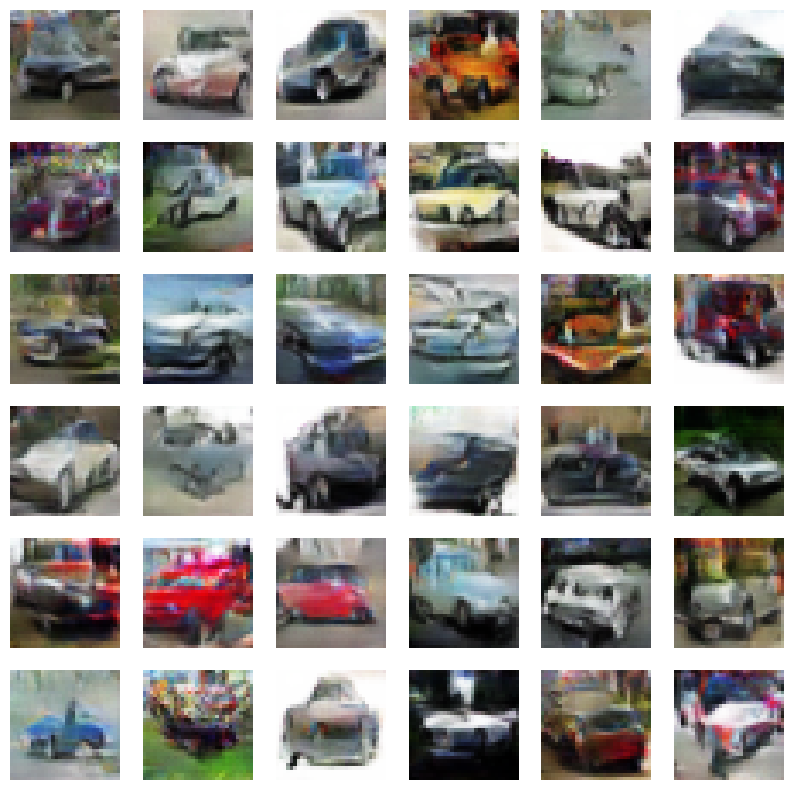

Currently on Epoch 171
Currently on Epoch 172
Currently on Epoch 173
Currently on Epoch 174
Currently on Epoch 175
	Discriminator Loss: [0.32371240854263306, 0.47265625] 		 Generator Loss: 3.043374538421631


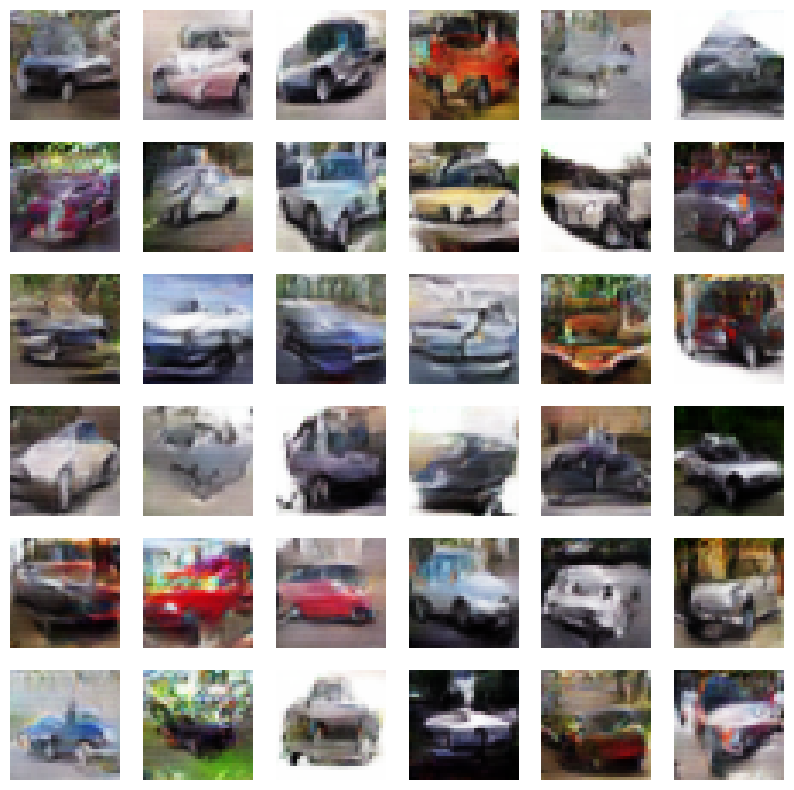

Currently on Epoch 176
Currently on Epoch 177
Currently on Epoch 178
Currently on Epoch 179
Currently on Epoch 180
	Discriminator Loss: [0.28348222374916077, 0.49609375] 		 Generator Loss: 2.5496087074279785


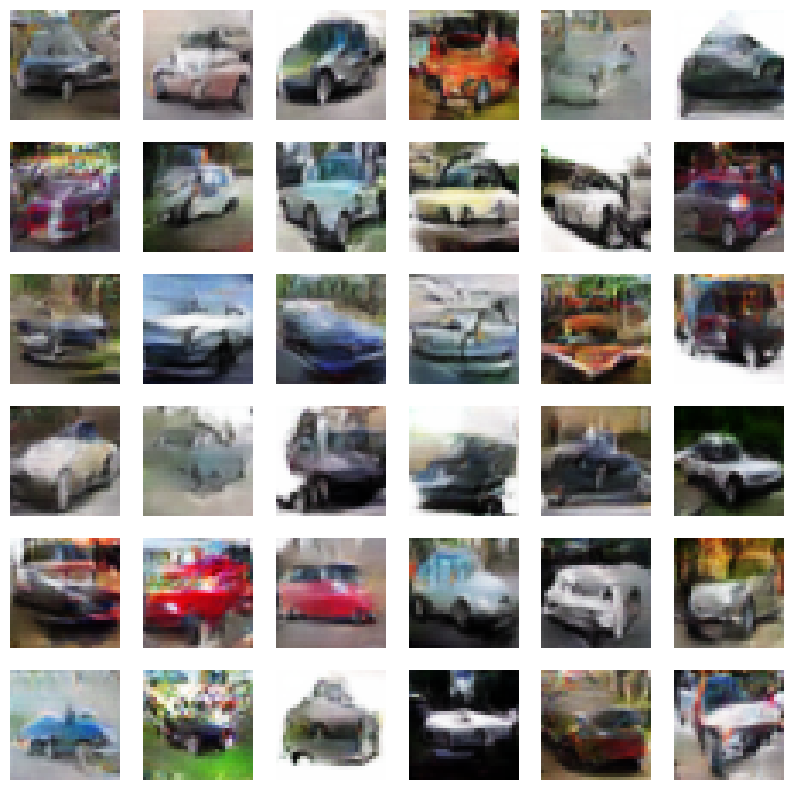

Currently on Epoch 181
Currently on Epoch 182
Currently on Epoch 183
Currently on Epoch 184
Currently on Epoch 185
	Discriminator Loss: [0.2800929844379425, 0.484375] 		 Generator Loss: 2.777885675430298


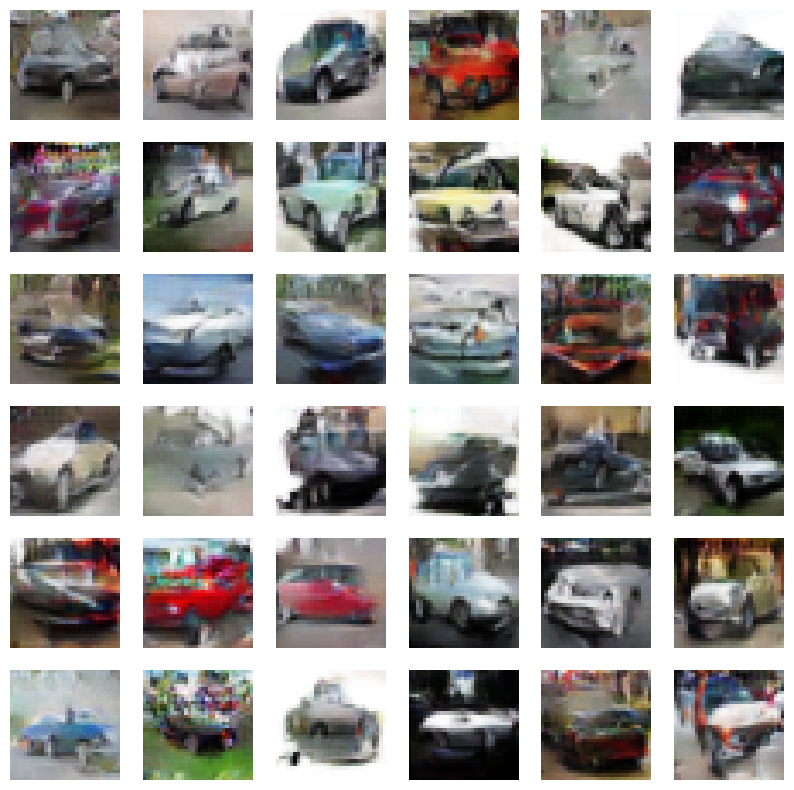

Currently on Epoch 186
Currently on Epoch 187
Currently on Epoch 188
Currently on Epoch 189
Currently on Epoch 190
	Discriminator Loss: [0.3290528953075409, 0.49609375] 		 Generator Loss: 2.7938287258148193


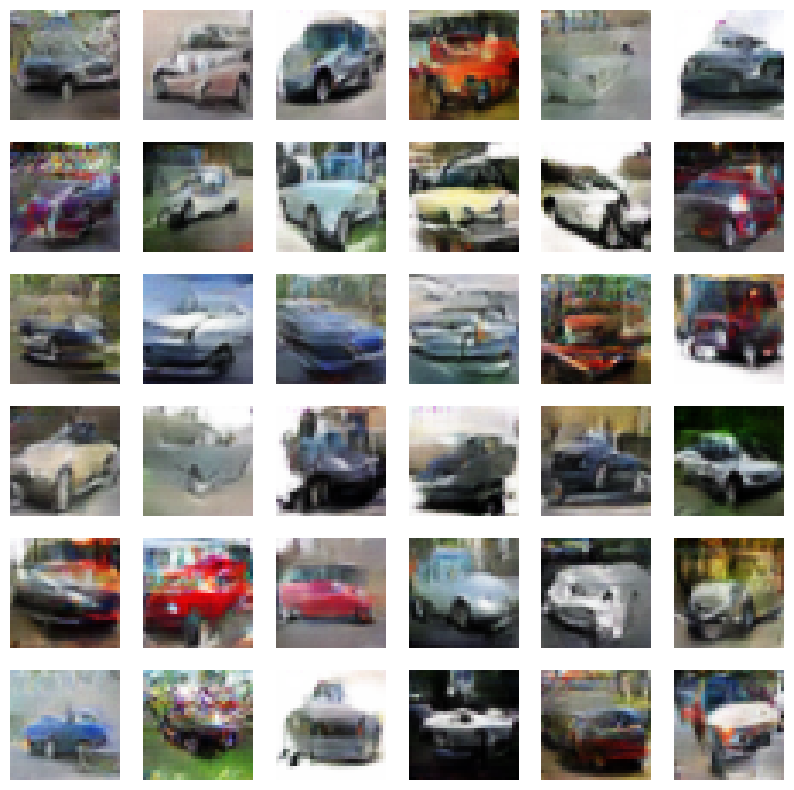

Currently on Epoch 191
Currently on Epoch 192
Currently on Epoch 193
Currently on Epoch 194
Currently on Epoch 195
	Discriminator Loss: [0.38191020488739014, 0.4296875] 		 Generator Loss: 4.07654333114624


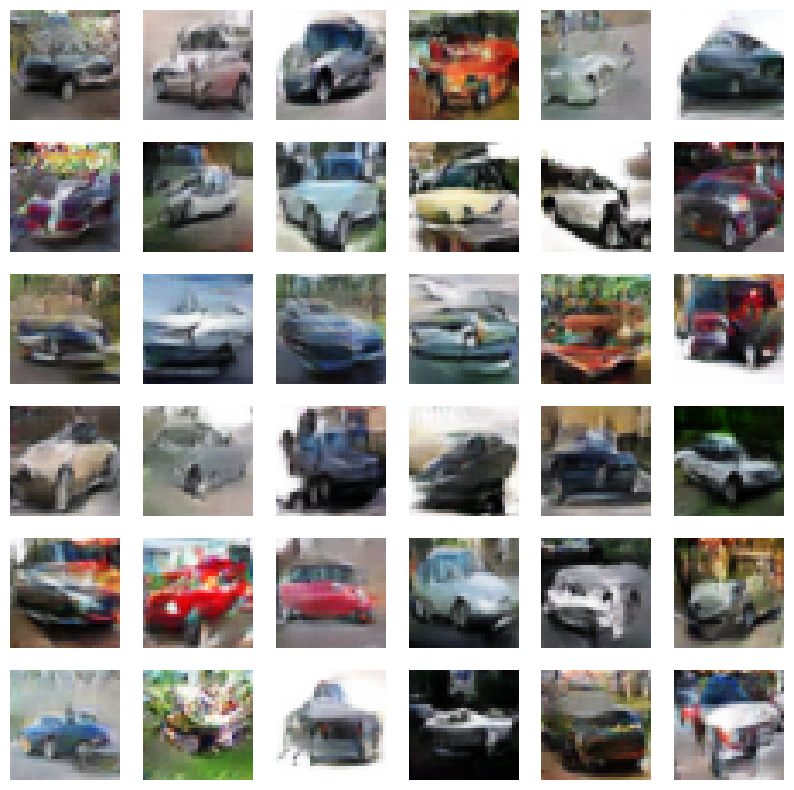

Currently on Epoch 196
Currently on Epoch 197
Currently on Epoch 198
Currently on Epoch 199
Currently on Epoch 200
	Discriminator Loss: [0.3784254193305969, 0.4453125] 		 Generator Loss: 3.7787108421325684


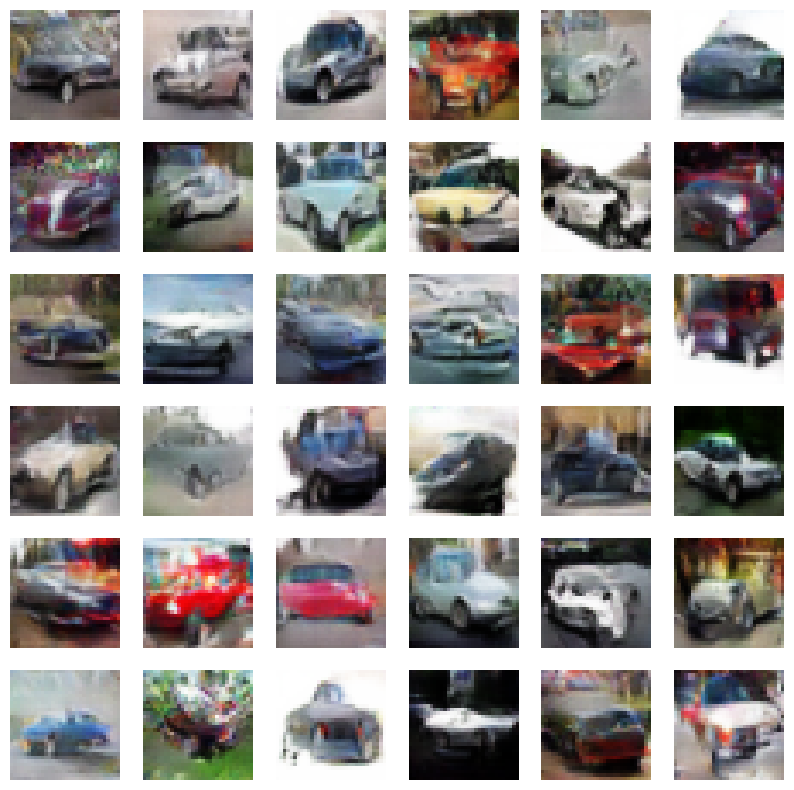

In [ ]:
d_model = define_discriminator()
g_model = define_generator(noise_dim)
gan_model = define_gan(g_model, d_model)
X_train, dataset = load_real_samples(BUFFER_SIZE, BATCH_SIZE)
static_noise = tf.random.normal([BATCH_SIZE, noise_dim])
train_model(EPOCHS, BATCH_SIZE, X_train, dataset, noise_dim, static_noise, gan_model)

# **2.B Optimizing Generator's Objective Function**

In the context of training Generative Adversarial Networks (GANs), the generator's objective is to fool the discriminator into thinking the generated samples are real. This is achieved by optimizing the generator's parameters.

The original objective function for the generator in a GAN is to minimize $$\mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]$$ where $D(G(z))$ is the discriminator's estimate of the probability that a generated image is real. This objective function is optimized using gradient descent.

However, in practice, this objective function can lead to poor results, especially during the early stages of training. The reason is that when the generator produces poor-quality images, the discriminator can easily distinguish them from real images, resulting in $D(G(z))$ being close to 0. This means that $\log(1 - D(G(z)))$ is close to 0, resulting in very small gradients. When the gradients are small, the generator's parameters are updated very slowly, which can lead to slow convergence or the model getting stuck in a poor solution.

To overcome this issue, practitioners often optimize a different objective function for the generator: $$\mathbb{E}_{z \sim p_z}[\log(D(G(z)))]$$ This objective function is optimized using gradient ascent, not descent. The idea is to directly maximize the probability that the discriminator is fooled, rather than minimizing the probability that it is not fooled. When the generator produces poor-quality images, $D(G(z))$ is close to 0, so $\log(D(G(z)))$ is a large negative number. This provides a strong gradient for updating the generator's parameters, leading to faster and more stable convergence.

In summary, the use of gradient ascent with the objective $\mathbb{E}_{z \sim p_z}[\log(D(G(z)))]$ is preferred over gradient descent with the objective $\mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]$ for training the generator in a GAN because it provides stronger gradients and leads to faster and more stable convergence. This is particularly important during the early stages of training when the generator is still producing poor-quality images.



Let's say the discriminator is very confident that a generated sample is fake, and assigns it a probability of 0.01. In the original formulation, the generator's loss would be $$-\log(1 - 0.01) = 0.01$$, which is a very small value and would result in a small gradient. In the reformulated objective, the generator's loss would be $$-\log(0.01) = 4.6$$, which is a much larger value and would result in a larger gradient, leading to more substantial updates to the generator's parameters.

In conclusion, while both gradient descent and gradient ascent are used in the training of GANs, the use of gradient ascent for the generator's objective function can help mitigate the vanishing gradients problem and lead to more effective training.


# **Part III**



### Transfer Learning for Small and Different Datasets

When your dataset is small and significantly different from the dataset used to train the pre-trained model, transfer learning can still be beneficial. The steps involve using the pre-trained model as a feature extractor and adding new layers for your specific task. This approach leverages the general features learned by the model and adapts them to your new dataset.

**Steps:**

1. **Use the Pre-trained Model as a Feature Extractor:**
   - Remove the last few layers of the pre-trained model, which are typically task-specific.
   - Use the remaining part of the model as a fixed feature extractor.

2. **Add New Layers for Your Task:**
   - Add new dense layers that suit your specific task (e.g., classification layers).

3. **Freeze the Pre-trained Layers:**
   - Freeze the layers of the pre-trained model to prevent them from being updated during training.

4. **Fine-tune the New Layers:**
   - Train the new layers on your small dataset to learn task-specific features.

**Example Using Python and TensorFlow:**



Load and preprocess the Dataset

we preprocess the dataset by reshaping the images and normalizing pixel values.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

In [ ]:
print("Fashion MNIST Dataset Information:")
print(f"Number of training examples: {len(train_images)}")
print(f"Number of test examples: {len(test_images)}")
print(f"Image shape: {train_images[0].shape}")
print(f"Number of classes: {len(set(train_labels))}")

Fashion MNIST Dataset Information:
Number of training examples: 60000
Number of test examples: 10000
Image shape: (28, 28, 1)
Number of classes: 10


Display some sample images

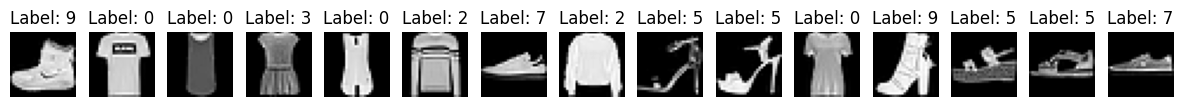

In [ ]:
plt.figure(figsize=(15, 4))
for i in range(15):
    plt.subplot(1, 15, i + 1)
    plt.imshow(train_images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.show()


Resize images to match VGG16 input shape (32x32x3) and convert grayscale images to RGB (3 channels)

In [ ]:
train_images = tf.image.resize(train_images, (32, 32))
test_images = tf.image.resize(test_images, (32, 32))

train_images = tf.concat([train_images] * 3, axis=-1)
test_images = tf.concat([test_images] * 3, axis=-1)

Define the base pre-trained model and freeze the base model

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in base_model.layers:
    layer.trainable = False

Create new layers for specific task.
Then, Create the new model, Compile the model and train it.

In [ ]:
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 17s 10ms/step - loss: 2.3081 - accuracy: 0.0982 - val_loss: 2.3025 - val_accuracy: 0.1009
Epoch 2/10
1563/1563 [==============================] - 16s 10ms/step - loss: 2.3028 - accuracy: 0.1008 - val_loss: 2.3026 - val_accuracy: 0.1038
Epoch 3/10
1563/1563 [==============================] - 16s 10ms/step - loss: 2.3027 - accuracy: 0.0995 - val_loss: 2.3026 - val_accuracy: 0.0991
Epoch 4/10
1563/1563 [==============================] - 16s 10ms/step - loss: 2.3028 - accuracy: 0.1005 - val_loss: 2.3025 - val_accuracy: 0.1030
Epoch 5/10
1563/1563 [==============================] - 16s 10ms/step - loss: 2.3027 - accuracy: 0.1010 - val_loss: 2.3025 - val_accuracy: 0.1038
Epoch 6/10
1563/1563 [==============================] - 16s 10ms/step - loss: 2.3027 - accuracy: 0.0988 - val_loss: 2.3026 - val_accuracy: 0.1011
Epoch 7/10
1563/1563 [==============================] - 16s 10ms/step - loss: 2.3027 - accuracy: 0.0987 - val_loss: 2.3025 -

Evaluate the model


In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 2s - loss: 0.3678 - accuracy: 0.8654 - 2s/epoch - 7ms/step

Test accuracy: 0.8654000163078308


### Transfer Learning for Small and Similar Datasets


When your dataset is small but similar to the dataset used to train the pre-trained model, you can fine-tune a greater portion of the model. This involves unfreezing some of the lower layers in addition to the top layers, which allows the model to adjust its general features to the specific nuances of your new dataset.

**Steps:**

1. **Load the Pre-trained Model:**
   - Load the pre-trained model including its top layers.

2. **Unfreeze a Subset of Layers:**
   - Unfreeze some of the lower layers of the model to allow them to be updated during training.

3. **Add New Layers if Necessary:**
   - Optionally, add a few new layers suited for your task.

4. **Adjust Learning Rate:**
   - Use a smaller learning rate for the unfrozen layers to avoid drastic changes to the weights.

5. **Fine-tune the Model:**
   - Train the model on your dataset to tweak the pre-trained features to better fit your new data.

**Example Using Python and TensorFlow:**





In [ ]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in base_model.layers[:15]:
    layer.trainable = True

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/10
1563/1563 [==============================] - 55s 31ms/step - loss: 0.9729 - accuracy: 0.6693 - val_loss: 0.5929 - val_accuracy: 0.7978
Epoch 2/10
1563/1563 [==============================] - 47s 30ms/step - loss: 0.5410 - accuracy: 0.8212 - val_loss: 0.5295 - val_accuracy: 0.8270
Epoch 3/10
1563/1563 [==============================] - 47s 30ms/step - loss: 0.3898 - accuracy: 0.8725 - val_loss: 0.4758 - val_accuracy: 0.8462
Epoch 4/10
1563/1563 [==============================] - 47s 30ms/step - loss: 0.2703 - accuracy: 0.9112 - val_loss: 0.5211 - val_accuracy: 0.8461
Epoch 5/10
1563/1563 [==============================] - 47s 30ms/step - loss: 0.1970 - accuracy: 0.9353 - val_loss: 0.5185 - val_accuracy: 0.8463
Epoch 6/10
1563/1563 [==============================] - 49s 32ms/step - loss: 0.1498 - accuracy: 0.9517 - val_loss: 0.6124 - val_accuracy: 0.8419
Epoch 7/10
1563/1563 [==============================] - 49s 31ms/step - loss: 0.1126 - accuracy: 0.9639 - val_loss: 0.5793 -

### Summary

- **For Very Different Datasets:** Use the pre-trained model as a feature extractor by freezing its layers and adding new layers for your specific task. Fine-tune only the new layers.
- **For Similar Datasets:** Unfreeze some of the lower layers of the pre-trained model and fine-tune a greater portion of the model. Add new layers if necessary and adjust the learning rate to avoid overfitting.

Both approaches leverage the strengths of transfer learning by adapting a pre-trained model to new, smaller datasets, while mitigating the risk of overfitting and maximizing the utility of the learned features.